# comparison mb size 50 with 2, 4 cores in frequency minimum

In [727]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


In [728]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format

In [729]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [730]:
def add_label_column_df(df):
    for index, row in df.iterrows():
        _str = row["algorithm"]

        if "RUNPER" in _str and row["batch_size"] == 1:
            df.at[index, 'label'] = "Parallel"
        elif row["batch_size"] == 1:
            df.at[index, 'label'] = "Seq"
        else:
            df.at[index, 'label'] = row["batch_size"]
            
    return df

In [731]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [732]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [733]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [734]:
import natsort

#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    df.iloc[natsort.index_humansorted([df.label, df.batch_size])]

    labels = df.label
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
    ax.plot(x, pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x, pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [735]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(by=['batch_size']), alg)
           # df_aux = df_aux.sort_values(by=['label'], ascending=True)
#             if tables:
#                 display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Algorithm Methodology')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [736]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/mini-batching-medium/600/1200/first"
wantedCSVfilename = "data-batch-vs-acc-600-1200.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = add_label_column_df(df)
df = df.drop(['cores', 'time'], axis=1)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

In [737]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/coletor-energia/mini-batching-mediumbatches/first/'

In [738]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [739]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate', 'acc']]

In [740]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [741]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                #print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [742]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [743]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

In [744]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, bsize, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

In [745]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [746]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [761]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.15

    df_mapping = pd.DataFrame({
        'label': ['MB', 'DVH2', 'DVH4', 'DVF2', 'DVF4', 'S'],
    })
    sort_mapping = df_mapping.reset_index().set_index('label')
    df['label_num'] = df['label'].map(sort_mapping['index'])

    df = df.drop_duplicates().sort_values('label_num')
    df = df[:-5]

    alg_order = ['MB', 'DVH2', 'DVH4', 'DVF2', 'DVF4', 'S']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', 'dashed', 'dotted', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 6
    for i in range(versions):
        adf = df.iloc[i]
        display(adf)
        values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [762]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#         display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
       
        # debug print, if it shows it is wrong
        # if len(showdf) != 5:
#         display(showdf)

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [770]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, freq='600', tput=False):
    ps = f'{freq}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']

    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=3, bbox_to_anchor=(0.5, -0.10))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

In [764]:
def read_data_create_final_dataframe(freq, DEBUG=True):
    d = {}
    global header_printed
    header_printed = False
    if freq['cores'] != None:
        folder_path = f"{PATH_TO_RESULTS}{freq['cores']}/{freq['minimum']}/{freq['maximum']}"
    else:
        folder_path = f"{PATH_TO_RESULTS}{freq['minimum']}/{freq['maximum']}"
    min = freq['minimum']
    max = freq['maximum']
    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-{max}-freq-min-{min}.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    
    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    finaldf['frequency_maximum'] = freq['maximum']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}tdf-{min}x{max}.csv")    
    return tdf

In [751]:
freqs = [{'minimum': '600', 'maximum': '1200', 'cores': None}]
dataframes = []
for f in freqs:
    dataframes.append(read_data_create_final_dataframe(f, True))

moaDF: 288    mdf: 288     sshDF: 288


In [752]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df.batch_size.unique()
    return df

In [753]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/coletor-energia/dpm/first/'

In [754]:
freqs = [
    {'minimum': '600', 'maximum': '600', 'cores': 2}, 
    {'minimum': '1200', 'maximum': '1200', 'cores': 2},
    {'minimum': '600', 'maximum': '600', 'cores': 4},
    {'minimum': '1200', 'maximum': '1200', 'cores': 4},
]

dataaframes_dvfs = []
for f in freqs:
    dataaframes_dvfs.append(read_data_create_final_dataframe(f, True))

# mergear o 0 com o 2 -> 600x600 2 cores e 600x600 4 cores
# mergear o 1 com o 3 -> 1200x1200 2 cores e 1200x1200 4 cores
dataframes_minimum_freq = pd.merge(dataaframes_dvfs[0], dataaframes_dvfs[2], how = 'outer')
dataframes_maximum_freq = pd.merge(dataaframes_dvfs[1], dataaframes_dvfs[3], how = 'outer')

# remove todas execucoes que nao sejam batch_size 50
df = dataframes[0]
df = df.drop(df[df.batch_size == 25].index)
df = df.drop(df[df.batch_size == 75].index)
df = df.drop(df[df.batch_size == 100].index)

# pega execução sequencial e bota em um novo dataframe
df_sequential = dataframes_maximum_freq.loc[(dataframes_maximum_freq.cores == 1) & (dataframes_maximum_freq.batch_size == 1)]

# remove todas execucoes sequenciais da frequencia minima
dataframes_minimum_freq = dataframes_minimum_freq.drop(dataframes_minimum_freq[dataframes_minimum_freq.algorithm.str.contains('Sequential') & (dataframes_maximum_freq.batch_size == 1)].index)
dataframes_minimum_freq = dataframes_minimum_freq.drop(dataframes_minimum_freq[(dataframes_minimum_freq.cores == 1) & (dataframes_minimum_freq.batch_size == 1)].index)

# remove todas execucoes sequenciais da frequencia maxima
dataframes_maximum_freq = dataframes_maximum_freq.drop(dataframes_maximum_freq[dataframes_maximum_freq.algorithm.str.contains('Sequential') & (dataframes_maximum_freq.batch_size == 1)].index)
dataframes_maximum_freq = dataframes_maximum_freq.drop(dataframes_maximum_freq[(dataframes_maximum_freq.cores == 1) & (dataframes_maximum_freq.batch_size == 1)].index)

# mergea a frequencia minima com mb e a frenquencia maxima com mb
dataframes_with_mb = pd.concat([df_sequential, df, dataframes_minimum_freq, dataframes_maximum_freq])



moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144


index_x                                  206
algorithm               AdaptiveRandomForest
dataset                             airlines
cores                                      4
batch_size                                50
inc_rate_x                                19
out_rate_10                            14.97
instances_10                        1,800.00
time_x                                120.25
delay_10                            2,087.00
acc_x                                  74.63
ensemble_size_x                           25
duration_x                               125
avg_measure_x                           3.97
sum_measure_x                         901.70
prod_rate_x                            14.98
tt_inst_prod_x                      1,800.00
avg_times_duration_x                  496.53
joules_10                             477.64
JPIold_x                                0.00
JPI_10                                  0.28
frequency_maximum_x                     1200
PERC_x    

index_x                                        107
algorithm               AdaptiveRandomForestRUNPER
dataset                                   airlines
cores                                            2
batch_size                                       1
inc_rate_x                                      15
out_rate_10                                  14.99
instances_10                              1,798.00
time_x                                      119.97
delay_10                                     67.00
acc_x                                        73.41
ensemble_size_x                                 25
duration_x                                     124
avg_measure_x                                 3.83
sum_measure_x                               861.70
prod_rate_x                                  14.98
tt_inst_prod_x                            1,800.00
avg_times_duration_x                        474.89
joules_10                                   459.47
JPIold_x                       

index_x                                        107
algorithm               AdaptiveRandomForestRUNPER
dataset                                   airlines
cores                                            2
batch_size                                       1
inc_rate_x                                       6
out_rate_10                                   4.98
instances_10                                598.00
time_x                                      120.00
delay_10                                     75.00
acc_x                                        72.74
ensemble_size_x                                 25
duration_x                                     126
avg_measure_x                                 3.28
sum_measure_x                               750.20
prod_rate_x                                   4.99
tt_inst_prod_x                              600.00
avg_times_duration_x                        412.77
joules_10                                   393.11
JPIold_x                       

index_x                                        107
algorithm               AdaptiveRandomForestRUNPER
dataset                                   airlines
cores                                            2
batch_size                                       1
inc_rate_x                                       6
out_rate_10                                   4.98
instances_10                                598.00
time_x                                      120.00
delay_10                                     75.00
acc_x                                        72.74
ensemble_size_x                                 25
duration_x                                     126
avg_measure_x                                 3.28
sum_measure_x                               750.20
prod_rate_x                                   4.99
tt_inst_prod_x                              600.00
avg_times_duration_x                        412.77
joules_10                                   393.11
JPIold_x                       

index_x                                        107
algorithm               AdaptiveRandomForestRUNPER
dataset                                   airlines
cores                                            2
batch_size                                       1
inc_rate_x                                      15
out_rate_10                                  14.99
instances_10                              1,798.00
time_x                                      119.97
delay_10                                     67.00
acc_x                                        73.41
ensemble_size_x                                 25
duration_x                                     124
avg_measure_x                                 3.83
sum_measure_x                               861.70
prod_rate_x                                  14.98
tt_inst_prod_x                            1,800.00
avg_times_duration_x                        474.89
joules_10                                   459.47
JPIold_x                       

index_x                                        251
algorithm               AdaptiveRandomForestRUNPER
dataset                                   airlines
cores                                            4
batch_size                                       1
inc_rate_x                                      15
out_rate_10                                  14.99
instances_10                              1,798.00
time_x                                      119.96
delay_10                                     28.00
acc_x                                        73.41
ensemble_size_x                                 25
duration_x                                     124
avg_measure_x                                 3.80
sum_measure_x                               855.60
prod_rate_x                                  14.98
tt_inst_prod_x                            1,800.00
avg_times_duration_x                        471.53
joules_10                                   456.17
JPIold_x                       

index_x                      131
algorithm                   LBag
dataset                 airlines
cores                          4
batch_size                    50
inc_rate_x                    17
out_rate_10                14.99
instances_10            1,800.00
time_x                    120.11
delay_10                1,954.00
acc_x                      72.74
ensemble_size_x               25
duration_x                   125
avg_measure_x               4.02
sum_measure_x             877.30
prod_rate_x                14.98
tt_inst_prod_x          1,800.00
avg_times_duration_x      503.04
joules_10                 483.38
JPIold_x                    0.00
JPI_10                      0.28
frequency_maximum_x         1200
PERC_x                        10
tput_10                    14.99
label_x                       MB
index_y                      123
inc_rate_y                    89
out_rate_50                79.57
instances_50            9,550.00
time_y                    120.03
delay_50  

index_x                        101
algorithm               LBagRUNPER
dataset                   airlines
cores                            2
batch_size                       1
inc_rate_x                      15
out_rate_10                  14.99
instances_10              1,798.00
time_x                      119.97
delay_10                    125.00
acc_x                        72.69
ensemble_size_x                 25
duration_x                     125
avg_measure_x                 3.63
sum_measure_x               794.20
prod_rate_x                  14.98
tt_inst_prod_x            1,800.00
avg_times_duration_x        453.31
joules_10                   435.09
JPIold_x                      0.00
JPI_10                        0.25
frequency_maximum_x           1200
PERC_x                          10
tput_10                      14.99
label_x                       DVF2
index_y                        100
inc_rate_y                      75
out_rate_50                  48.70
instances_50        

index_x                        101
algorithm               LBagRUNPER
dataset                   airlines
cores                            2
batch_size                       1
inc_rate_x                       5
out_rate_10                   4.99
instances_10                598.00
time_x                      119.94
delay_10                     86.00
acc_x                        75.92
ensemble_size_x                 25
duration_x                     128
avg_measure_x                 3.28
sum_measure_x               760.10
prod_rate_x                   4.99
tt_inst_prod_x              600.00
avg_times_duration_x        419.37
joules_10                   392.95
JPIold_x                      0.01
JPI_10                        0.70
frequency_maximum_x            600
PERC_x                          10
tput_10                       4.99
label_x                       DVH2
index_y                        100
inc_rate_y                      75
out_rate_50                  48.70
instances_50        

index_x                        101
algorithm               LBagRUNPER
dataset                   airlines
cores                            2
batch_size                       1
inc_rate_x                       5
out_rate_10                   4.99
instances_10                598.00
time_x                      119.94
delay_10                     86.00
acc_x                        75.92
ensemble_size_x                 25
duration_x                     128
avg_measure_x                 3.28
sum_measure_x               760.10
prod_rate_x                   4.99
tt_inst_prod_x              600.00
avg_times_duration_x        419.37
joules_10                   392.95
JPIold_x                      0.01
JPI_10                        0.70
frequency_maximum_x            600
PERC_x                          10
tput_10                       4.99
label_x                       DVH2
index_y                        100
inc_rate_y                      28
out_rate_50                  24.33
instances_50        

index_x                        101
algorithm               LBagRUNPER
dataset                   airlines
cores                            2
batch_size                       1
inc_rate_x                      15
out_rate_10                  14.99
instances_10              1,798.00
time_x                      119.97
delay_10                    125.00
acc_x                        72.69
ensemble_size_x                 25
duration_x                     125
avg_measure_x                 3.63
sum_measure_x               794.20
prod_rate_x                  14.98
tt_inst_prod_x            1,800.00
avg_times_duration_x        453.31
joules_10                   435.09
JPIold_x                      0.00
JPI_10                        0.25
frequency_maximum_x           1200
PERC_x                          10
tput_10                      14.99
label_x                       DVF2
index_y                        100
inc_rate_y                      28
out_rate_50                  24.33
instances_50        

index_x                        245
algorithm               LBagRUNPER
dataset                   airlines
cores                            4
batch_size                       1
inc_rate_x                      15
out_rate_10                  14.99
instances_10              1,798.00
time_x                      119.97
delay_10                     15.00
acc_x                        72.69
ensemble_size_x                 25
duration_x                     126
avg_measure_x                 3.65
sum_measure_x               835.10
prod_rate_x                  14.98
tt_inst_prod_x            1,800.00
avg_times_duration_x        459.49
joules_10                   437.50
JPIold_x                      0.00
JPI_10                        0.26
frequency_maximum_x           1200
PERC_x                          10
tput_10                      14.99
label_x                       DVF4
index_y                        244
inc_rate_y                      75
out_rate_50                  60.34
instances_50        

index_x                                    207
algorithm               StreamingRandomPatches
dataset                               airlines
cores                                        4
batch_size                                  50
inc_rate_x                                  17
out_rate_10                              14.88
instances_10                          1,800.00
time_x                                  120.98
delay_10                              2,172.00
acc_x                                    75.49
ensemble_size_x                             25
duration_x                                 125
avg_measure_x                             4.15
sum_measure_x                           937.40
prod_rate_x                              14.98
tt_inst_prod_x                        1,800.00
avg_times_duration_x                    518.47
joules_10                               501.82
JPIold_x                                  0.00
JPI_10                                    0.29
frequency_max

index_x                                           74
algorithm               StreamingRandomPatchesRUNPER
dataset                                     airlines
cores                                              2
batch_size                                         1
inc_rate_x                                        15
out_rate_10                                    14.98
instances_10                                1,798.00
time_x                                        119.99
delay_10                                      116.00
acc_x                                          74.36
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.77
sum_measure_x                                 856.60
prod_rate_x                                    14.98
tt_inst_prod_x                              1,800.00
avg_times_duration_x                          471.70
joules_10                                     

index_x                                           74
algorithm               StreamingRandomPatchesRUNPER
dataset                                     airlines
cores                                              2
batch_size                                         1
inc_rate_x                                         5
out_rate_10                                     4.99
instances_10                                  598.00
time_x                                        119.96
delay_10                                      140.00
acc_x                                          75.75
ensemble_size_x                                   25
duration_x                                       126
avg_measure_x                                   3.27
sum_measure_x                                 749.40
prod_rate_x                                     4.99
tt_inst_prod_x                                600.00
avg_times_duration_x                          412.33
joules_10                                     

index_x                                           74
algorithm               StreamingRandomPatchesRUNPER
dataset                                     airlines
cores                                              2
batch_size                                         1
inc_rate_x                                         5
out_rate_10                                     4.99
instances_10                                  598.00
time_x                                        119.96
delay_10                                      140.00
acc_x                                          75.75
ensemble_size_x                                   25
duration_x                                       126
avg_measure_x                                   3.27
sum_measure_x                                 749.40
prod_rate_x                                     4.99
tt_inst_prod_x                                600.00
avg_times_duration_x                          412.33
joules_10                                     

index_x                                           74
algorithm               StreamingRandomPatchesRUNPER
dataset                                     airlines
cores                                              2
batch_size                                         1
inc_rate_x                                        15
out_rate_10                                    14.98
instances_10                                1,798.00
time_x                                        119.99
delay_10                                      116.00
acc_x                                          74.36
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.77
sum_measure_x                                 856.60
prod_rate_x                                    14.98
tt_inst_prod_x                              1,800.00
avg_times_duration_x                          471.70
joules_10                                     

index_x                                          218
algorithm               StreamingRandomPatchesRUNPER
dataset                                     airlines
cores                                              4
batch_size                                         1
inc_rate_x                                        15
out_rate_10                                    14.99
instances_10                                1,798.00
time_x                                        119.98
delay_10                                       39.00
acc_x                                          74.36
ensemble_size_x                                   25
duration_x                                       124
avg_measure_x                                   3.85
sum_measure_x                                 846.60
prod_rate_x                                    14.98
tt_inst_prod_x                              1,800.00
avg_times_duration_x                          477.17
joules_10                                     

index_x                          63
algorithm               OzaBagAdwin
dataset                    airlines
cores                             4
batch_size                       50
inc_rate_x                       53
out_rate_10                   49.98
instances_10               6,000.00
time_x                       120.05
delay_10                     519.00
acc_x                         66.74
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  3.88
sum_measure_x                880.60
prod_rate_x                   49.93
tt_inst_prod_x             6,000.00
avg_times_duration_x         484.91
joules_10                    465.71
JPIold_x                       0.00
JPI_10                         0.08
frequency_maximum_x            1200
PERC_x                           10
tput_10                       49.98
label_x                          MB
index_y                          52
inc_rate_y                      266
out_rate_50                 

index_x                                83
algorithm               OzaBagAdwinRUNPER
dataset                          airlines
cores                                   2
batch_size                              1
inc_rate_x                             22
out_rate_10                         19.99
instances_10                     2,398.00
time_x                             119.97
delay_10                            65.00
acc_x                               72.23
ensemble_size_x                        25
duration_x                            126
avg_measure_x                        3.62
sum_measure_x                      825.40
prod_rate_x                         19.98
tt_inst_prod_x                   2,400.00
avg_times_duration_x               456.14
joules_10                          434.31
JPIold_x                             0.00
JPI_10                               0.19
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                                83
algorithm               OzaBagAdwinRUNPER
dataset                          airlines
cores                                   2
batch_size                              1
inc_rate_x                             10
out_rate_10                          9.99
instances_10                     1,198.00
time_x                             119.96
delay_10                           192.00
acc_x                               74.21
ensemble_size_x                        25
duration_x                            128
avg_measure_x                        3.28
sum_measure_x                      760.00
prod_rate_x                          9.99
tt_inst_prod_x                   1,200.00
avg_times_duration_x               419.31
joules_10                          392.96
JPIold_x                             0.00
JPI_10                               0.35
frequency_maximum_x                   600
PERC_x                                 10
tput_10                           

index_x                                83
algorithm               OzaBagAdwinRUNPER
dataset                          airlines
cores                                   2
batch_size                              1
inc_rate_x                             10
out_rate_10                          9.99
instances_10                     1,198.00
time_x                             119.96
delay_10                           192.00
acc_x                               74.21
ensemble_size_x                        25
duration_x                            128
avg_measure_x                        3.28
sum_measure_x                      760.00
prod_rate_x                          9.99
tt_inst_prod_x                   1,200.00
avg_times_duration_x               419.31
joules_10                          392.96
JPIold_x                             0.00
JPI_10                               0.35
frequency_maximum_x                   600
PERC_x                                 10
tput_10                           

index_x                                83
algorithm               OzaBagAdwinRUNPER
dataset                          airlines
cores                                   2
batch_size                              1
inc_rate_x                             22
out_rate_10                         19.99
instances_10                     2,398.00
time_x                             119.97
delay_10                            65.00
acc_x                               72.23
ensemble_size_x                        25
duration_x                            126
avg_measure_x                        3.62
sum_measure_x                      825.40
prod_rate_x                         19.98
tt_inst_prod_x                   2,400.00
avg_times_duration_x               456.14
joules_10                          434.31
JPIold_x                             0.00
JPI_10                               0.19
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                               227
algorithm               OzaBagAdwinRUNPER
dataset                          airlines
cores                                   4
batch_size                              1
inc_rate_x                             22
out_rate_10                         19.99
instances_10                     2,398.00
time_x                             119.96
delay_10                            18.00
acc_x                               72.23
ensemble_size_x                        25
duration_x                            126
avg_measure_x                        3.60
sum_measure_x                      824.00
prod_rate_x                         19.98
tt_inst_prod_x                   2,400.00
avg_times_duration_x               453.38
joules_10                          431.65
JPIold_x                             0.00
JPI_10                               0.19
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                        245
algorithm               OzaBagASHT
dataset                   airlines
cores                            4
batch_size                      50
inc_rate_x                     150
out_rate_10                 149.75
instances_10             17,971.00
time_x                      120.01
delay_10                    246.00
acc_x                        63.06
ensemble_size_x                 25
duration_x                     125
avg_measure_x                 5.33
sum_measure_x             1,215.60
prod_rate_x                 149.75
tt_inst_prod_x           18,000.00
avg_times_duration_x        666.45
joules_10                   639.82
JPIold_x                      0.00
JPI_10                        0.04
frequency_maximum_x           1200
PERC_x                          10
tput_10                     149.75
label_x                         MB
index_y                        239
inc_rate_y                     754
out_rate_50                 310.71
instances_50        

index_x                               89
algorithm               OzaBagASHTRUNPER
dataset                         airlines
cores                                  2
batch_size                             1
inc_rate_x                            55
out_rate_10                        54.89
instances_10                    6,588.00
time_x                            120.01
delay_10                          317.00
acc_x                              65.44
ensemble_size_x                       25
duration_x                           125
avg_measure_x                       3.86
sum_measure_x                     872.00
prod_rate_x                        54.92
tt_inst_prod_x                  6,600.00
avg_times_duration_x              482.30
joules_10                         463.06
JPIold_x                            0.00
JPI_10                              0.07
frequency_maximum_x                 1200
PERC_x                                10
tput_10                            54.89
label_x         

index_x                               89
algorithm               OzaBagASHTRUNPER
dataset                         airlines
cores                                  2
batch_size                             1
inc_rate_x                            23
out_rate_10                        19.99
instances_10                    2,398.00
time_x                            119.96
delay_10                          548.00
acc_x                              72.19
ensemble_size_x                       25
duration_x                           129
avg_measure_x                       3.30
sum_measure_x                     773.30
prod_rate_x                        19.98
tt_inst_prod_x                  2,400.00
avg_times_duration_x              426.31
joules_10                         396.45
JPIold_x                            0.00
JPI_10                              0.18
frequency_maximum_x                  600
PERC_x                                10
tput_10                            19.99
label_x         

index_x                               89
algorithm               OzaBagASHTRUNPER
dataset                         airlines
cores                                  2
batch_size                             1
inc_rate_x                            23
out_rate_10                        19.99
instances_10                    2,398.00
time_x                            119.96
delay_10                          548.00
acc_x                              72.19
ensemble_size_x                       25
duration_x                           129
avg_measure_x                       3.30
sum_measure_x                     773.30
prod_rate_x                        19.98
tt_inst_prod_x                  2,400.00
avg_times_duration_x              426.31
joules_10                         396.45
JPIold_x                            0.00
JPI_10                              0.18
frequency_maximum_x                  600
PERC_x                                10
tput_10                            19.99
label_x         

index_x                               89
algorithm               OzaBagASHTRUNPER
dataset                         airlines
cores                                  2
batch_size                             1
inc_rate_x                            55
out_rate_10                        54.89
instances_10                    6,588.00
time_x                            120.01
delay_10                          317.00
acc_x                              65.44
ensemble_size_x                       25
duration_x                           125
avg_measure_x                       3.86
sum_measure_x                     872.00
prod_rate_x                        54.92
tt_inst_prod_x                  6,600.00
avg_times_duration_x              482.30
joules_10                         463.06
JPIold_x                            0.00
JPI_10                              0.07
frequency_maximum_x                 1200
PERC_x                                10
tput_10                            54.89
label_x         

index_x                              233
algorithm               OzaBagASHTRUNPER
dataset                         airlines
cores                                  4
batch_size                             1
inc_rate_x                            55
out_rate_10                        54.89
instances_10                    6,588.00
time_x                            120.01
delay_10                           86.00
acc_x                              65.44
ensemble_size_x                       25
duration_x                           126
avg_measure_x                       3.93
sum_measure_x                     901.00
prod_rate_x                        54.92
tt_inst_prod_x                  6,600.00
avg_times_duration_x              495.75
joules_10                         472.19
JPIold_x                            0.00
JPI_10                              0.08
frequency_maximum_x                 1200
PERC_x                                10
tput_10                            54.89
label_x         

index_x                       155
algorithm                  OzaBag
dataset                  airlines
cores                           4
batch_size                     50
inc_rate_x                    180
out_rate_10                179.83
instances_10            21,564.00
time_x                     119.91
delay_10                   226.00
acc_x                       63.33
ensemble_size_x                25
duration_x                    125
avg_measure_x                5.20
sum_measure_x            1,176.30
prod_rate_x                179.69
tt_inst_prod_x          21,564.00
avg_times_duration_x       650.61
joules_10                  624.13
JPIold_x                     0.00
JPI_10                       0.03
frequency_maximum_x          1200
PERC_x                         10
tput_10                    179.83
label_x                        MB
index_y                       108
inc_rate_y                    904
out_rate_50                220.40
instances_50            26,800.00
time_y        

index_x                           80
algorithm               OzaBagRUNPER
dataset                     airlines
cores                              2
batch_size                         1
inc_rate_x                        80
out_rate_10                    79.85
instances_10                9,582.00
time_x                        120.00
delay_10                      844.00
acc_x                          63.10
ensemble_size_x                   25
duration_x                       126
avg_measure_x                   4.23
sum_measure_x                 968.10
prod_rate_x                    79.87
tt_inst_prod_x              9,600.00
avg_times_duration_x          532.67
joules_10                     507.32
JPIold_x                        0.00
JPI_10                          0.06
frequency_maximum_x             1200
PERC_x                            10
tput_10                        79.85
label_x                         DVF2
index_y                           79
inc_rate_y                       402
o

index_x                           80
algorithm               OzaBagRUNPER
dataset                     airlines
cores                              2
batch_size                         1
inc_rate_x                        36
out_rate_10                    34.94
instances_10                4,193.00
time_x                        120.02
delay_10                    1,135.00
acc_x                          68.52
ensemble_size_x                   25
duration_x                       128
avg_measure_x                   3.35
sum_measure_x                 748.10
prod_rate_x                    34.95
tt_inst_prod_x              4,200.00
avg_times_duration_x          429.40
joules_10                     402.63
JPIold_x                        0.00
JPI_10                          0.10
frequency_maximum_x              600
PERC_x                            10
tput_10                        34.94
label_x                         DVH2
index_y                           79
inc_rate_y                       402
o

index_x                           80
algorithm               OzaBagRUNPER
dataset                     airlines
cores                              2
batch_size                         1
inc_rate_x                        36
out_rate_10                    34.94
instances_10                4,193.00
time_x                        120.02
delay_10                    1,135.00
acc_x                          68.52
ensemble_size_x                   25
duration_x                       128
avg_measure_x                   3.35
sum_measure_x                 748.10
prod_rate_x                    34.95
tt_inst_prod_x              4,200.00
avg_times_duration_x          429.40
joules_10                     402.63
JPIold_x                        0.00
JPI_10                          0.10
frequency_maximum_x              600
PERC_x                            10
tput_10                        34.94
label_x                         DVH2
index_y                           79
inc_rate_y                       182
o

index_x                           80
algorithm               OzaBagRUNPER
dataset                     airlines
cores                              2
batch_size                         1
inc_rate_x                        80
out_rate_10                    79.85
instances_10                9,582.00
time_x                        120.00
delay_10                      844.00
acc_x                          63.10
ensemble_size_x                   25
duration_x                       126
avg_measure_x                   4.23
sum_measure_x                 968.10
prod_rate_x                    79.87
tt_inst_prod_x              9,600.00
avg_times_duration_x          532.67
joules_10                     507.32
JPIold_x                        0.00
JPI_10                          0.06
frequency_maximum_x             1200
PERC_x                            10
tput_10                        79.85
label_x                         DVF2
index_y                           79
inc_rate_y                       182
o

index_x                          224
algorithm               OzaBagRUNPER
dataset                     airlines
cores                              4
batch_size                         1
inc_rate_x                        80
out_rate_10                    79.79
instances_10                9,579.00
time_x                        120.05
delay_10                      183.00
acc_x                          63.11
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   4.25
sum_measure_x                 964.80
prod_rate_x                    79.87
tt_inst_prod_x              9,600.00
avg_times_duration_x          531.28
joules_10                     510.25
JPIold_x                        0.00
JPI_10                          0.06
frequency_maximum_x             1200
PERC_x                            10
tput_10                        79.79
label_x                         DVF4
index_y                          223
inc_rate_y                       402
o

index_x                                   34
algorithm               AdaptiveRandomForest
dataset                                 GMSC
cores                                      4
batch_size                                50
inc_rate_x                               111
out_rate_10                           109.82
instances_10                       13,179.00
time_x                                120.01
delay_10                              259.00
acc_x                                  93.41
ensemble_size_x                           25
duration_x                               124
avg_measure_x                           3.94
sum_measure_x                         881.80
prod_rate_x                           109.82
tt_inst_prod_x                     13,200.00
avg_times_duration_x                  488.14
joules_10                             472.43
JPIold_x                                0.00
JPI_10                                  0.04
frequency_maximum_x                     1200
PERC_x    

index_x                                        143
algorithm               AdaptiveRandomForestRUNPER
dataset                                       GMSC
cores                                            2
batch_size                                       1
inc_rate_x                                      70
out_rate_10                                  69.89
instances_10                              8,387.00
time_x                                      120.00
delay_10                                     64.00
acc_x                                        93.55
ensemble_size_x                                 25
duration_x                                     123
avg_measure_x                                 3.55
sum_measure_x                               791.40
prod_rate_x                                  69.89
tt_inst_prod_x                            8,400.00
avg_times_duration_x                        436.51
joules_10                                   425.88
JPIold_x                       

index_x                                        143
algorithm               AdaptiveRandomForestRUNPER
dataset                                       GMSC
cores                                            2
batch_size                                       1
inc_rate_x                                      32
out_rate_10                                  30.01
instances_10                              3,600.00
time_x                                      119.98
delay_10                                    148.00
acc_x                                        94.14
ensemble_size_x                                 25
duration_x                                     126
avg_measure_x                                 3.20
sum_measure_x                               730.30
prod_rate_x                                  29.96
tt_inst_prod_x                            3,600.00
avg_times_duration_x                        403.59
joules_10                                   384.30
JPIold_x                       

index_x                                        143
algorithm               AdaptiveRandomForestRUNPER
dataset                                       GMSC
cores                                            2
batch_size                                       1
inc_rate_x                                      32
out_rate_10                                  30.01
instances_10                              3,600.00
time_x                                      119.98
delay_10                                    148.00
acc_x                                        94.14
ensemble_size_x                                 25
duration_x                                     126
avg_measure_x                                 3.20
sum_measure_x                               730.30
prod_rate_x                                  29.96
tt_inst_prod_x                            3,600.00
avg_times_duration_x                        403.59
joules_10                                   384.30
JPIold_x                       

index_x                                        143
algorithm               AdaptiveRandomForestRUNPER
dataset                                       GMSC
cores                                            2
batch_size                                       1
inc_rate_x                                      70
out_rate_10                                  69.89
instances_10                              8,387.00
time_x                                      120.00
delay_10                                     64.00
acc_x                                        93.55
ensemble_size_x                                 25
duration_x                                     123
avg_measure_x                                 3.55
sum_measure_x                               791.40
prod_rate_x                                  69.89
tt_inst_prod_x                            8,400.00
avg_times_duration_x                        436.51
joules_10                                   425.88
JPIold_x                       

index_x                                        287
algorithm               AdaptiveRandomForestRUNPER
dataset                                       GMSC
cores                                            4
batch_size                                       1
inc_rate_x                                      70
out_rate_10                                  69.91
instances_10                              8,389.00
time_x                                      120.00
delay_10                                     28.00
acc_x                                        93.55
ensemble_size_x                                 25
duration_x                                     124
avg_measure_x                                 3.54
sum_measure_x                               793.80
prod_rate_x                                  69.89
tt_inst_prod_x                            8,400.00
avg_times_duration_x                        439.42
joules_10                                   425.25
JPIold_x                       

index_x                        25
algorithm                    LBag
dataset                      GMSC
cores                           4
batch_size                     50
inc_rate_x                    156
out_rate_10                154.94
instances_10            18,569.00
time_x                     119.85
delay_10                   185.00
acc_x                       93.53
ensemble_size_x                25
duration_x                    125
avg_measure_x                3.93
sum_measure_x              876.30
prod_rate_x                154.73
tt_inst_prod_x          18,569.00
avg_times_duration_x       491.20
joules_10                  470.95
JPIold_x                     0.00
JPI_10                       0.03
frequency_maximum_x          1200
PERC_x                         10
tput_10                    154.94
label_x                        MB
index_y                       115
inc_rate_y                    782
out_rate_50                777.80
instances_50            93,350.00
time_y        

index_x                        137
algorithm               LBagRUNPER
dataset                       GMSC
cores                            2
batch_size                       1
inc_rate_x                      90
out_rate_10                  89.86
instances_10             10,783.00
time_x                      120.00
delay_10                     36.00
acc_x                        93.29
ensemble_size_x                 25
duration_x                     126
avg_measure_x                 3.53
sum_measure_x               795.10
prod_rate_x                  89.85
tt_inst_prod_x           10,800.00
avg_times_duration_x        445.26
joules_10                   424.07
JPIold_x                      0.00
JPI_10                        0.04
frequency_maximum_x           1200
PERC_x                          10
tput_10                      89.86
label_x                       DVF2
index_y                        136
inc_rate_y                     452
out_rate_50                 448.92
instances_50        

index_x                        137
algorithm               LBagRUNPER
dataset                       GMSC
cores                            2
batch_size                       1
inc_rate_x                      41
out_rate_10                  39.93
instances_10              4,794.00
time_x                      120.05
delay_10                     77.00
acc_x                        93.58
ensemble_size_x                 25
duration_x                     128
avg_measure_x                 3.21
sum_measure_x               745.70
prod_rate_x                  39.94
tt_inst_prod_x            4,800.00
avg_times_duration_x        411.42
joules_10                   385.85
JPIold_x                      0.00
JPI_10                        0.09
frequency_maximum_x            600
PERC_x                          10
tput_10                      39.93
label_x                       DVH2
index_y                        136
inc_rate_y                     452
out_rate_50                 448.92
instances_50        

index_x                        137
algorithm               LBagRUNPER
dataset                       GMSC
cores                            2
batch_size                       1
inc_rate_x                      41
out_rate_10                  39.93
instances_10              4,794.00
time_x                      120.05
delay_10                     77.00
acc_x                        93.58
ensemble_size_x                 25
duration_x                     128
avg_measure_x                 3.21
sum_measure_x               745.70
prod_rate_x                  39.94
tt_inst_prod_x            4,800.00
avg_times_duration_x        411.42
joules_10                   385.85
JPIold_x                      0.00
JPI_10                        0.09
frequency_maximum_x            600
PERC_x                          10
tput_10                      39.93
label_x                       DVH2
index_y                        136
inc_rate_y                     205
out_rate_50                 204.84
instances_50        

index_x                        137
algorithm               LBagRUNPER
dataset                       GMSC
cores                            2
batch_size                       1
inc_rate_x                      90
out_rate_10                  89.86
instances_10             10,783.00
time_x                      120.00
delay_10                     36.00
acc_x                        93.29
ensemble_size_x                 25
duration_x                     126
avg_measure_x                 3.53
sum_measure_x               795.10
prod_rate_x                  89.85
tt_inst_prod_x           10,800.00
avg_times_duration_x        445.26
joules_10                   424.07
JPIold_x                      0.00
JPI_10                        0.04
frequency_maximum_x           1200
PERC_x                          10
tput_10                      89.86
label_x                       DVF2
index_y                        136
inc_rate_y                     205
out_rate_50                 204.84
instances_50        

index_x                        281
algorithm               LBagRUNPER
dataset                       GMSC
cores                            4
batch_size                       1
inc_rate_x                      90
out_rate_10                  89.86
instances_10             10,783.00
time_x                      120.00
delay_10                     20.00
acc_x                        93.29
ensemble_size_x                 25
duration_x                     126
avg_measure_x                 3.55
sum_measure_x               812.70
prod_rate_x                  89.85
tt_inst_prod_x           10,800.00
avg_times_duration_x        447.16
joules_10                   425.88
JPIold_x                      0.00
JPI_10                        0.04
frequency_maximum_x           1200
PERC_x                          10
tput_10                      89.86
label_x                       DVF4
index_y                        280
inc_rate_y                     452
out_rate_50                 448.99
instances_50        

index_x                                    198
algorithm               StreamingRandomPatches
dataset                                   GMSC
cores                                        4
batch_size                                  50
inc_rate_x                                  63
out_rate_10                              59.98
instances_10                          7,200.00
time_x                                  120.05
delay_10                                475.00
acc_x                                    93.65
ensemble_size_x                             25
duration_x                                 123
avg_measure_x                             3.86
sum_measure_x                           861.50
prod_rate_x                              59.91
tt_inst_prod_x                        7,200.00
avg_times_duration_x                    475.18
joules_10                               463.78
JPIold_x                                  0.00
JPI_10                                    0.07
frequency_max

index_x                                          110
algorithm               StreamingRandomPatchesRUNPER
dataset                                         GMSC
cores                                              2
batch_size                                         1
inc_rate_x                                        33
out_rate_10                                    30.00
instances_10                                3,600.00
time_x                                        119.99
delay_10                                       42.00
acc_x                                          94.19
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.50
sum_measure_x                                 793.50
prod_rate_x                                    29.96
tt_inst_prod_x                              3,600.00
avg_times_duration_x                          436.95
joules_10                                     

index_x                                          110
algorithm               StreamingRandomPatchesRUNPER
dataset                                         GMSC
cores                                              2
batch_size                                         1
inc_rate_x                                        17
out_rate_10                                    15.00
instances_10                                1,800.00
time_x                                        119.96
delay_10                                      121.00
acc_x                                          94.33
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.20
sum_measure_x                                 727.00
prod_rate_x                                    14.98
tt_inst_prod_x                              1,800.00
avg_times_duration_x                          400.33
joules_10                                     

index_x                                          110
algorithm               StreamingRandomPatchesRUNPER
dataset                                         GMSC
cores                                              2
batch_size                                         1
inc_rate_x                                        17
out_rate_10                                    15.00
instances_10                                1,800.00
time_x                                        119.96
delay_10                                      121.00
acc_x                                          94.33
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.20
sum_measure_x                                 727.00
prod_rate_x                                    14.98
tt_inst_prod_x                              1,800.00
avg_times_duration_x                          400.33
joules_10                                     

index_x                                          110
algorithm               StreamingRandomPatchesRUNPER
dataset                                         GMSC
cores                                              2
batch_size                                         1
inc_rate_x                                        33
out_rate_10                                    30.00
instances_10                                3,600.00
time_x                                        119.99
delay_10                                       42.00
acc_x                                          94.19
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.50
sum_measure_x                                 793.50
prod_rate_x                                    29.96
tt_inst_prod_x                              3,600.00
avg_times_duration_x                          436.95
joules_10                                     

index_x                                          254
algorithm               StreamingRandomPatchesRUNPER
dataset                                         GMSC
cores                                              4
batch_size                                         1
inc_rate_x                                        33
out_rate_10                                    30.00
instances_10                                3,600.00
time_x                                        119.99
delay_10                                       22.00
acc_x                                          94.19
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.50
sum_measure_x                                 791.00
prod_rate_x                                    29.96
tt_inst_prod_x                              3,600.00
avg_times_duration_x                          437.50
joules_10                                     

index_x                         136
algorithm               OzaBagAdwin
dataset                        GMSC
cores                             4
batch_size                       50
inc_rate_x                      364
out_rate_10                  359.73
instances_10              43,128.00
time_x                       119.89
delay_10                      76.00
acc_x                         93.41
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  3.87
sum_measure_x                878.30
prod_rate_x                  359.19
tt_inst_prod_x            43,128.00
avg_times_duration_x         483.65
joules_10                    463.87
JPIold_x                       0.00
JPI_10                         0.01
frequency_maximum_x            1200
PERC_x                           10
tput_10                      359.73
label_x                          MB
index_y                          35
inc_rate_y                     1821
out_rate_50                1

index_x                               119
algorithm               OzaBagAdwinRUNPER
dataset                              GMSC
cores                                   2
batch_size                              1
inc_rate_x                            175
out_rate_10                        174.93
instances_10                    20,965.00
time_x                             119.85
delay_10                            46.00
acc_x                               93.61
ensemble_size_x                        25
duration_x                            125
avg_measure_x                        3.55
sum_measure_x                      809.50
prod_rate_x                        174.69
tt_inst_prod_x                  20,965.00
avg_times_duration_x               443.80
joules_10                          425.52
JPIold_x                             0.00
JPI_10                               0.02
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                               119
algorithm               OzaBagAdwinRUNPER
dataset                              GMSC
cores                                   2
batch_size                              1
inc_rate_x                             72
out_rate_10                         69.89
instances_10                     8,388.00
time_x                             120.01
delay_10                            62.00
acc_x                               93.62
ensemble_size_x                        25
duration_x                            128
avg_measure_x                        3.21
sum_measure_x                      744.60
prod_rate_x                         69.89
tt_inst_prod_x                   8,400.00
avg_times_duration_x               410.81
joules_10                          385.18
JPIold_x                             0.00
JPI_10                               0.05
frequency_maximum_x                   600
PERC_x                                 10
tput_10                           

index_x                               119
algorithm               OzaBagAdwinRUNPER
dataset                              GMSC
cores                                   2
batch_size                              1
inc_rate_x                             72
out_rate_10                         69.89
instances_10                     8,388.00
time_x                             120.01
delay_10                            62.00
acc_x                               93.62
ensemble_size_x                        25
duration_x                            128
avg_measure_x                        3.21
sum_measure_x                      744.60
prod_rate_x                         69.89
tt_inst_prod_x                   8,400.00
avg_times_duration_x               410.81
joules_10                          385.18
JPIold_x                             0.00
JPI_10                               0.05
frequency_maximum_x                   600
PERC_x                                 10
tput_10                           

index_x                               119
algorithm               OzaBagAdwinRUNPER
dataset                              GMSC
cores                                   2
batch_size                              1
inc_rate_x                            175
out_rate_10                        174.93
instances_10                    20,965.00
time_x                             119.85
delay_10                            46.00
acc_x                               93.61
ensemble_size_x                        25
duration_x                            125
avg_measure_x                        3.55
sum_measure_x                      809.50
prod_rate_x                        174.69
tt_inst_prod_x                  20,965.00
avg_times_duration_x               443.80
joules_10                          425.52
JPIold_x                             0.00
JPI_10                               0.02
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                               263
algorithm               OzaBagAdwinRUNPER
dataset                              GMSC
cores                                   4
batch_size                              1
inc_rate_x                            175
out_rate_10                        174.92
instances_10                    20,965.00
time_x                             119.85
delay_10                            20.00
acc_x                               93.61
ensemble_size_x                        25
duration_x                            126
avg_measure_x                        3.54
sum_measure_x                      790.10
prod_rate_x                        174.70
tt_inst_prod_x                  20,965.00
avg_times_duration_x               446.42
joules_10                          424.64
JPIold_x                             0.00
JPI_10                               0.02
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                        208
algorithm               OzaBagASHT
dataset                       GMSC
cores                            4
batch_size                      50
inc_rate_x                     406
out_rate_10                 404.63
instances_10             48,519.00
time_x                      119.91
delay_10                     68.00
acc_x                        93.37
ensemble_size_x                 25
duration_x                     126
avg_measure_x                 3.85
sum_measure_x               882.00
prod_rate_x                 404.04
tt_inst_prod_x           48,519.00
avg_times_duration_x        485.29
joules_10                   461.84
JPIold_x                      0.00
JPI_10                        0.01
frequency_maximum_x           1200
PERC_x                          10
tput_10                     404.63
label_x                         MB
index_y                        174
inc_rate_y                    2033
out_rate_50               2,025.74
instances_50        

index_x                              125
algorithm               OzaBagASHTRUNPER
dataset                             GMSC
cores                                  2
batch_size                             1
inc_rate_x                           191
out_rate_10                       189.90
instances_10                   22,762.00
time_x                            119.86
delay_10                           34.00
acc_x                              93.61
ensemble_size_x                       25
duration_x                           126
avg_measure_x                       3.55
sum_measure_x                     812.30
prod_rate_x                       189.66
tt_inst_prod_x                 22,762.00
avg_times_duration_x              446.94
joules_10                         425.17
JPIold_x                            0.00
JPI_10                              0.02
frequency_maximum_x                 1200
PERC_x                                10
tput_10                           189.90
label_x         

index_x                              125
algorithm               OzaBagASHTRUNPER
dataset                             GMSC
cores                                  2
batch_size                             1
inc_rate_x                            89
out_rate_10                        84.87
instances_10                   10,185.00
time_x                            120.00
delay_10                           71.00
acc_x                              93.58
ensemble_size_x                       25
duration_x                           128
avg_measure_x                       3.18
sum_measure_x                     712.10
prod_rate_x                        84.87
tt_inst_prod_x                 10,200.00
avg_times_duration_x              406.91
joules_10                         381.49
JPIold_x                            0.00
JPI_10                              0.04
frequency_maximum_x                  600
PERC_x                                10
tput_10                            84.87
label_x         

index_x                              125
algorithm               OzaBagASHTRUNPER
dataset                             GMSC
cores                                  2
batch_size                             1
inc_rate_x                            89
out_rate_10                        84.87
instances_10                   10,185.00
time_x                            120.00
delay_10                           71.00
acc_x                              93.58
ensemble_size_x                       25
duration_x                           128
avg_measure_x                       3.18
sum_measure_x                     712.10
prod_rate_x                        84.87
tt_inst_prod_x                 10,200.00
avg_times_duration_x              406.91
joules_10                         381.49
JPIold_x                            0.00
JPI_10                              0.04
frequency_maximum_x                  600
PERC_x                                10
tput_10                            84.87
label_x         

index_x                              125
algorithm               OzaBagASHTRUNPER
dataset                             GMSC
cores                                  2
batch_size                             1
inc_rate_x                           191
out_rate_10                       189.90
instances_10                   22,762.00
time_x                            119.86
delay_10                           34.00
acc_x                              93.61
ensemble_size_x                       25
duration_x                           126
avg_measure_x                       3.55
sum_measure_x                     812.30
prod_rate_x                       189.66
tt_inst_prod_x                 22,762.00
avg_times_duration_x              446.94
joules_10                         425.17
JPIold_x                            0.00
JPI_10                              0.02
frequency_maximum_x                 1200
PERC_x                                10
tput_10                           189.90
label_x         

index_x                              269
algorithm               OzaBagASHTRUNPER
dataset                             GMSC
cores                                  4
batch_size                             1
inc_rate_x                           191
out_rate_10                       189.95
instances_10                   22,762.00
time_x                            119.83
delay_10                           17.00
acc_x                              93.61
ensemble_size_x                       25
duration_x                           125
avg_measure_x                       3.51
sum_measure_x                     793.30
prod_rate_x                       189.67
tt_inst_prod_x                 22,762.00
avg_times_duration_x              438.77
joules_10                         420.62
JPIold_x                            0.00
JPI_10                              0.02
frequency_maximum_x                 1200
PERC_x                                10
tput_10                           189.95
label_x         

index_x                       248
algorithm                  OzaBag
dataset                      GMSC
cores                           4
batch_size                     50
inc_rate_x                    391
out_rate_10                389.62
instances_10            46,722.00
time_x                     119.92
delay_10                    70.00
acc_x                       93.51
ensemble_size_x                25
duration_x                    126
avg_measure_x                3.83
sum_measure_x              873.20
prod_rate_x                389.10
tt_inst_prod_x          46,722.00
avg_times_duration_x       482.56
joules_10                  459.26
JPIold_x                     0.00
JPI_10                       0.01
frequency_maximum_x          1200
PERC_x                         10
tput_10                    389.62
label_x                        MB
index_y                       246
inc_rate_y                   1955
out_rate_50              1,951.02
instances_50           150,000.00
time_y        

index_x                          116
algorithm               OzaBagRUNPER
dataset                         GMSC
cores                              2
batch_size                         1
inc_rate_x                       184
out_rate_10                   179.93
instances_10               21,564.00
time_x                        119.85
delay_10                       34.00
acc_x                          93.63
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   3.52
sum_measure_x                 795.20
prod_rate_x                   179.69
tt_inst_prod_x             21,564.00
avg_times_duration_x          439.82
joules_10                     421.70
JPIold_x                        0.00
JPI_10                          0.02
frequency_maximum_x             1200
PERC_x                            10
tput_10                       179.93
label_x                         DVF2
index_y                          115
inc_rate_y                       924
o

index_x                          116
algorithm               OzaBagRUNPER
dataset                         GMSC
cores                              2
batch_size                         1
inc_rate_x                        87
out_rate_10                    84.86
instances_10               10,184.00
time_x                        120.00
delay_10                       74.00
acc_x                          93.51
ensemble_size_x                   25
duration_x                       128
avg_measure_x                   3.18
sum_measure_x                 738.60
prod_rate_x                    84.86
tt_inst_prod_x             10,200.00
avg_times_duration_x          407.50
joules_10                     382.05
JPIold_x                        0.00
JPI_10                          0.04
frequency_maximum_x              600
PERC_x                            10
tput_10                        84.86
label_x                         DVH2
index_y                          115
inc_rate_y                       924
o

index_x                          116
algorithm               OzaBagRUNPER
dataset                         GMSC
cores                              2
batch_size                         1
inc_rate_x                        87
out_rate_10                    84.86
instances_10               10,184.00
time_x                        120.00
delay_10                       74.00
acc_x                          93.51
ensemble_size_x                   25
duration_x                       128
avg_measure_x                   3.18
sum_measure_x                 738.60
prod_rate_x                    84.86
tt_inst_prod_x             10,200.00
avg_times_duration_x          407.50
joules_10                     382.05
JPIold_x                        0.00
JPI_10                          0.04
frequency_maximum_x              600
PERC_x                            10
tput_10                        84.86
label_x                         DVH2
index_y                          115
inc_rate_y                       436
o

index_x                          116
algorithm               OzaBagRUNPER
dataset                         GMSC
cores                              2
batch_size                         1
inc_rate_x                       184
out_rate_10                   179.93
instances_10               21,564.00
time_x                        119.85
delay_10                       34.00
acc_x                          93.63
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   3.52
sum_measure_x                 795.20
prod_rate_x                   179.69
tt_inst_prod_x             21,564.00
avg_times_duration_x          439.82
joules_10                     421.70
JPIold_x                        0.00
JPI_10                          0.02
frequency_maximum_x             1200
PERC_x                            10
tput_10                       179.93
label_x                         DVF2
index_y                          115
inc_rate_y                       436
o

index_x                          260
algorithm               OzaBagRUNPER
dataset                         GMSC
cores                              4
batch_size                         1
inc_rate_x                       184
out_rate_10                   179.90
instances_10               21,564.00
time_x                        119.87
delay_10                       17.00
acc_x                          93.63
ensemble_size_x                   25
duration_x                       126
avg_measure_x                   3.50
sum_measure_x                 801.70
prod_rate_x                   179.69
tt_inst_prod_x             21,564.00
avg_times_duration_x          441.11
joules_10                     419.64
JPIold_x                        0.00
JPI_10                          0.02
frequency_maximum_x             1200
PERC_x                            10
tput_10                       179.90
label_x                         DVF4
index_y                          259
inc_rate_y                       924
o

index_x                                  107
algorithm               AdaptiveRandomForest
dataset                          elecNormNew
cores                                      4
batch_size                                50
inc_rate_x                                77
out_rate_10                            74.88
instances_10                        8,986.00
time_x                                120.01
delay_10                              370.00
acc_x                                  80.90
ensemble_size_x                           25
duration_x                               124
avg_measure_x                           4.05
sum_measure_x                         912.30
prod_rate_x                            74.88
tt_inst_prod_x                      9,000.00
avg_times_duration_x                  502.78
joules_10                             486.59
JPIold_x                                0.00
JPI_10                                  0.06
frequency_maximum_x                     1200
PERC_x    

index_x                                         35
algorithm               AdaptiveRandomForestRUNPER
dataset                                elecNormNew
cores                                            2
batch_size                                       1
inc_rate_x                                      43
out_rate_10                                  39.96
instances_10                              4,795.00
time_x                                      120.00
delay_10                                     31.00
acc_x                                        88.82
ensemble_size_x                                 25
duration_x                                     124
avg_measure_x                                 3.64
sum_measure_x                               818.00
prod_rate_x                                  39.94
tt_inst_prod_x                            4,800.00
avg_times_duration_x                        450.81
joules_10                                   436.27
JPIold_x                       

index_x                                         35
algorithm               AdaptiveRandomForestRUNPER
dataset                                elecNormNew
cores                                            2
batch_size                                       1
inc_rate_x                                      20
out_rate_10                                  20.00
instances_10                              2,400.00
time_x                                      119.99
delay_10                                     72.00
acc_x                                        86.96
ensemble_size_x                                 25
duration_x                                     126
avg_measure_x                                 3.23
sum_measure_x                               739.30
prod_rate_x                                  19.98
tt_inst_prod_x                            2,400.00
avg_times_duration_x                        406.78
joules_10                                   387.36
JPIold_x                       

index_x                                         35
algorithm               AdaptiveRandomForestRUNPER
dataset                                elecNormNew
cores                                            2
batch_size                                       1
inc_rate_x                                      20
out_rate_10                                  20.00
instances_10                              2,400.00
time_x                                      119.99
delay_10                                     72.00
acc_x                                        86.96
ensemble_size_x                                 25
duration_x                                     126
avg_measure_x                                 3.23
sum_measure_x                               739.30
prod_rate_x                                  19.98
tt_inst_prod_x                            2,400.00
avg_times_duration_x                        406.78
joules_10                                   387.36
JPIold_x                       

index_x                                         35
algorithm               AdaptiveRandomForestRUNPER
dataset                                elecNormNew
cores                                            2
batch_size                                       1
inc_rate_x                                      43
out_rate_10                                  39.96
instances_10                              4,795.00
time_x                                      120.00
delay_10                                     31.00
acc_x                                        88.82
ensemble_size_x                                 25
duration_x                                     124
avg_measure_x                                 3.64
sum_measure_x                               818.00
prod_rate_x                                  39.94
tt_inst_prod_x                            4,800.00
avg_times_duration_x                        450.81
joules_10                                   436.27
JPIold_x                       

index_x                                        179
algorithm               AdaptiveRandomForestRUNPER
dataset                                elecNormNew
cores                                            4
batch_size                                       1
inc_rate_x                                      43
out_rate_10                                  40.00
instances_10                              4,800.00
time_x                                      120.00
delay_10                                     17.00
acc_x                                        88.81
ensemble_size_x                                 25
duration_x                                     124
avg_measure_x                                 3.54
sum_measure_x                               797.10
prod_rate_x                                  39.94
tt_inst_prod_x                            4,800.00
avg_times_duration_x                        439.29
joules_10                                   425.12
JPIold_x                       

index_x                         261
algorithm                      LBag
dataset                 elecNormNew
cores                             4
batch_size                       50
inc_rate_x                      113
out_rate_10                  109.82
instances_10              13,179.00
time_x                       120.00
delay_10                     259.00
acc_x                         83.21
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  4.09
sum_measure_x                927.80
prod_rate_x                  109.82
tt_inst_prod_x            13,200.00
avg_times_duration_x         510.90
joules_10                    490.49
JPIold_x                       0.00
JPI_10                         0.04
frequency_maximum_x            1200
PERC_x                           10
tput_10                      109.82
label_x                          MB
index_y                         156
inc_rate_y                      565
out_rate_50                 

index_x                          29
algorithm                LBagRUNPER
dataset                 elecNormNew
cores                             2
batch_size                        1
inc_rate_x                       68
out_rate_10                   64.90
instances_10               7,788.00
time_x                       120.01
delay_10                      61.00
acc_x                         91.23
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  3.57
sum_measure_x                810.60
prod_rate_x                   64.90
tt_inst_prod_x             7,800.00
avg_times_duration_x         446.37
joules_10                    428.53
JPIold_x                       0.00
JPI_10                         0.06
frequency_maximum_x            1200
PERC_x                           10
tput_10                       64.90
label_x                        DVF2
index_y                          28
inc_rate_y                      344
out_rate_50                 

index_x                          29
algorithm                LBagRUNPER
dataset                 elecNormNew
cores                             2
batch_size                        1
inc_rate_x                       30
out_rate_10                   30.01
instances_10               3,600.00
time_x                       119.98
delay_10                      85.00
acc_x                         90.89
ensemble_size_x                  25
duration_x                      128
avg_measure_x                  3.23
sum_measure_x                748.90
prod_rate_x                   29.96
tt_inst_prod_x             3,600.00
avg_times_duration_x         413.19
joules_10                    387.29
JPIold_x                       0.00
JPI_10                         0.11
frequency_maximum_x             600
PERC_x                           10
tput_10                       30.01
label_x                        DVH2
index_y                          28
inc_rate_y                      344
out_rate_50                 

index_x                          29
algorithm                LBagRUNPER
dataset                 elecNormNew
cores                             2
batch_size                        1
inc_rate_x                       30
out_rate_10                   30.01
instances_10               3,600.00
time_x                       119.98
delay_10                      85.00
acc_x                         90.89
ensemble_size_x                  25
duration_x                      128
avg_measure_x                  3.23
sum_measure_x                748.90
prod_rate_x                   29.96
tt_inst_prod_x             3,600.00
avg_times_duration_x         413.19
joules_10                    387.29
JPIold_x                       0.00
JPI_10                         0.11
frequency_maximum_x             600
PERC_x                           10
tput_10                       30.01
label_x                        DVH2
index_y                          28
inc_rate_y                      153
out_rate_50                 

index_x                          29
algorithm                LBagRUNPER
dataset                 elecNormNew
cores                             2
batch_size                        1
inc_rate_x                       68
out_rate_10                   64.90
instances_10               7,788.00
time_x                       120.01
delay_10                      61.00
acc_x                         91.23
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  3.57
sum_measure_x                810.60
prod_rate_x                   64.90
tt_inst_prod_x             7,800.00
avg_times_duration_x         446.37
joules_10                    428.53
JPIold_x                       0.00
JPI_10                         0.06
frequency_maximum_x            1200
PERC_x                           10
tput_10                       64.90
label_x                        DVF2
index_y                          28
inc_rate_y                      153
out_rate_50                 

index_x                         173
algorithm                LBagRUNPER
dataset                 elecNormNew
cores                             4
batch_size                        1
inc_rate_x                       68
out_rate_10                   64.90
instances_10               7,788.00
time_x                       120.01
delay_10                      16.00
acc_x                         91.23
ensemble_size_x                  25
duration_x                      126
avg_measure_x                  3.60
sum_measure_x                824.20
prod_rate_x                   64.89
tt_inst_prod_x             7,800.00
avg_times_duration_x         453.49
joules_10                    431.92
JPIold_x                       0.00
JPI_10                         0.06
frequency_maximum_x            1200
PERC_x                           10
tput_10                       64.90
label_x                        DVF4
index_y                         172
inc_rate_y                      344
out_rate_50                 

index_x                                      8
algorithm               StreamingRandomPatches
dataset                            elecNormNew
cores                                        4
batch_size                                  50
inc_rate_x                                  39
out_rate_10                              34.99
instances_10                          4,200.00
time_x                                  120.04
delay_10                                820.00
acc_x                                    82.48
ensemble_size_x                             25
duration_x                                 123
avg_measure_x                             3.83
sum_measure_x                           854.80
prod_rate_x                              34.95
tt_inst_prod_x                        4,200.00
avg_times_duration_x                    471.48
joules_10                               460.15
JPIold_x                                  0.00
JPI_10                                    0.11
frequency_max

index_x                                            2
algorithm               StreamingRandomPatchesRUNPER
dataset                                  elecNormNew
cores                                              2
batch_size                                         1
inc_rate_x                                        25
out_rate_10                                    25.00
instances_10                                3,000.00
time_x                                        119.99
delay_10                                       39.00
acc_x                                          92.07
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.57
sum_measure_x                                 809.60
prod_rate_x                                    24.97
tt_inst_prod_x                              3,000.00
avg_times_duration_x                          445.81
joules_10                                     

index_x                                            2
algorithm               StreamingRandomPatchesRUNPER
dataset                                  elecNormNew
cores                                              2
batch_size                                         1
inc_rate_x                                        10
out_rate_10                                    10.00
instances_10                                1,200.00
time_x                                        119.96
delay_10                                       82.00
acc_x                                          90.58
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.21
sum_measure_x                                 725.70
prod_rate_x                                     9.99
tt_inst_prod_x                              1,200.00
avg_times_duration_x                          401.38
joules_10                                     

index_x                                            2
algorithm               StreamingRandomPatchesRUNPER
dataset                                  elecNormNew
cores                                              2
batch_size                                         1
inc_rate_x                                        10
out_rate_10                                    10.00
instances_10                                1,200.00
time_x                                        119.96
delay_10                                       82.00
acc_x                                          90.58
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.21
sum_measure_x                                 725.70
prod_rate_x                                     9.99
tt_inst_prod_x                              1,200.00
avg_times_duration_x                          401.38
joules_10                                     

index_x                                            2
algorithm               StreamingRandomPatchesRUNPER
dataset                                  elecNormNew
cores                                              2
batch_size                                         1
inc_rate_x                                        25
out_rate_10                                    25.00
instances_10                                3,000.00
time_x                                        119.99
delay_10                                       39.00
acc_x                                          92.07
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.57
sum_measure_x                                 809.60
prod_rate_x                                    24.97
tt_inst_prod_x                              3,000.00
avg_times_duration_x                          445.81
joules_10                                     

index_x                                          146
algorithm               StreamingRandomPatchesRUNPER
dataset                                  elecNormNew
cores                                              4
batch_size                                         1
inc_rate_x                                        25
out_rate_10                                    25.00
instances_10                                3,000.00
time_x                                        119.98
delay_10                                       20.00
acc_x                                          92.07
ensemble_size_x                                   25
duration_x                                       124
avg_measure_x                                   3.58
sum_measure_x                                 791.50
prod_rate_x                                    24.97
tt_inst_prod_x                              3,000.00
avg_times_duration_x                          444.10
joules_10                                     

index_x                         268
algorithm               OzaBagAdwin
dataset                 elecNormNew
cores                             4
batch_size                       50
inc_rate_x                      214
out_rate_10                  209.89
instances_10              25,158.00
time_x                       119.86
delay_10                     130.00
acc_x                         81.64
ensemble_size_x                  25
duration_x                      126
avg_measure_x                  3.88
sum_measure_x                889.10
prod_rate_x                  209.59
tt_inst_prod_x            25,158.00
avg_times_duration_x         489.20
joules_10                    465.37
JPIold_x                       0.00
JPI_10                         0.02
frequency_maximum_x            1200
PERC_x                           10
tput_10                      209.89
label_x                          MB
index_y                         230
inc_rate_y                     1072
out_rate_50                1

index_x                                11
algorithm               OzaBagAdwinRUNPER
dataset                       elecNormNew
cores                                   2
batch_size                              1
inc_rate_x                            115
out_rate_10                        114.96
instances_10                    13,777.00
time_x                             119.85
delay_10                            62.00
acc_x                               90.23
ensemble_size_x                        25
duration_x                            125
avg_measure_x                        3.57
sum_measure_x                      806.00
prod_rate_x                        114.79
tt_inst_prod_x                  13,777.00
avg_times_duration_x               445.80
joules_10                          427.42
JPIold_x                             0.00
JPI_10                               0.03
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                                11
algorithm               OzaBagAdwinRUNPER
dataset                       elecNormNew
cores                                   2
batch_size                              1
inc_rate_x                             49
out_rate_10                         45.00
instances_10                     5,400.00
time_x                             120.00
delay_10                            88.00
acc_x                               90.54
ensemble_size_x                        25
duration_x                            128
avg_measure_x                        3.21
sum_measure_x                      743.60
prod_rate_x                         44.93
tt_inst_prod_x                   5,400.00
avg_times_duration_x               410.26
joules_10                          384.61
JPIold_x                             0.00
JPI_10                               0.08
frequency_maximum_x                   600
PERC_x                                 10
tput_10                           

index_x                                11
algorithm               OzaBagAdwinRUNPER
dataset                       elecNormNew
cores                                   2
batch_size                              1
inc_rate_x                             49
out_rate_10                         45.00
instances_10                     5,400.00
time_x                             120.00
delay_10                            88.00
acc_x                               90.54
ensemble_size_x                        25
duration_x                            128
avg_measure_x                        3.21
sum_measure_x                      743.60
prod_rate_x                         44.93
tt_inst_prod_x                   5,400.00
avg_times_duration_x               410.26
joules_10                          384.61
JPIold_x                             0.00
JPI_10                               0.08
frequency_maximum_x                   600
PERC_x                                 10
tput_10                           

index_x                                11
algorithm               OzaBagAdwinRUNPER
dataset                       elecNormNew
cores                                   2
batch_size                              1
inc_rate_x                            115
out_rate_10                        114.96
instances_10                    13,777.00
time_x                             119.85
delay_10                            62.00
acc_x                               90.23
ensemble_size_x                        25
duration_x                            125
avg_measure_x                        3.57
sum_measure_x                      806.00
prod_rate_x                        114.79
tt_inst_prod_x                  13,777.00
avg_times_duration_x               445.80
joules_10                          427.42
JPIold_x                             0.00
JPI_10                               0.03
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                               155
algorithm               OzaBagAdwinRUNPER
dataset                       elecNormNew
cores                                   4
batch_size                              1
inc_rate_x                            115
out_rate_10                        114.96
instances_10                    13,777.00
time_x                             119.84
delay_10                            23.00
acc_x                               90.23
ensemble_size_x                        25
duration_x                            126
avg_measure_x                        3.55
sum_measure_x                      813.00
prod_rate_x                        114.80
tt_inst_prod_x                  13,777.00
avg_times_duration_x               447.33
joules_10                          425.46
JPIold_x                             0.00
JPI_10                               0.03
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                         114
algorithm                OzaBagASHT
dataset                 elecNormNew
cores                             4
batch_size                       50
inc_rate_x                      271
out_rate_10                  269.83
instances_10              32,346.00
time_x                       119.88
delay_10                      99.00
acc_x                         78.99
ensemble_size_x                  25
duration_x                      126
avg_measure_x                  3.85
sum_measure_x                878.20
prod_rate_x                  269.42
tt_inst_prod_x            32,346.00
avg_times_duration_x         485.32
joules_10                    461.74
JPIold_x                       0.00
JPI_10                         0.02
frequency_maximum_x            1200
PERC_x                           10
tput_10                      269.83
label_x                          MB
index_y                         146
inc_rate_y                     1355
out_rate_50                1

index_x                               17
algorithm               OzaBagASHTRUNPER
dataset                      elecNormNew
cores                                  2
batch_size                             1
inc_rate_x                           134
out_rate_10                       129.97
instances_10                   15,574.00
time_x                            119.83
delay_10                           44.00
acc_x                              88.14
ensemble_size_x                       25
duration_x                           126
avg_measure_x                       3.52
sum_measure_x                     801.60
prod_rate_x                       129.77
tt_inst_prod_x                 15,574.00
avg_times_duration_x              442.99
joules_10                         421.29
JPIold_x                            0.00
JPI_10                              0.03
frequency_maximum_x                 1200
PERC_x                                10
tput_10                           129.97
label_x         

index_x                               17
algorithm               OzaBagASHTRUNPER
dataset                      elecNormNew
cores                                  2
batch_size                             1
inc_rate_x                            61
out_rate_10                        59.92
instances_10                    7,190.00
time_x                            120.00
delay_10                          126.00
acc_x                              88.50
ensemble_size_x                       25
duration_x                           128
avg_measure_x                       3.21
sum_measure_x                     718.90
prod_rate_x                        59.91
tt_inst_prod_x                  7,200.00
avg_times_duration_x              410.80
joules_10                         385.13
JPIold_x                            0.00
JPI_10                              0.06
frequency_maximum_x                  600
PERC_x                                10
tput_10                            59.92
label_x         

index_x                               17
algorithm               OzaBagASHTRUNPER
dataset                      elecNormNew
cores                                  2
batch_size                             1
inc_rate_x                            61
out_rate_10                        59.92
instances_10                    7,190.00
time_x                            120.00
delay_10                          126.00
acc_x                              88.50
ensemble_size_x                       25
duration_x                           128
avg_measure_x                       3.21
sum_measure_x                     718.90
prod_rate_x                        59.91
tt_inst_prod_x                  7,200.00
avg_times_duration_x              410.80
joules_10                         385.13
JPIold_x                            0.00
JPI_10                              0.06
frequency_maximum_x                  600
PERC_x                                10
tput_10                            59.92
label_x         

index_x                               17
algorithm               OzaBagASHTRUNPER
dataset                      elecNormNew
cores                                  2
batch_size                             1
inc_rate_x                           134
out_rate_10                       129.97
instances_10                   15,574.00
time_x                            119.83
delay_10                           44.00
acc_x                              88.14
ensemble_size_x                       25
duration_x                           126
avg_measure_x                       3.52
sum_measure_x                     801.60
prod_rate_x                       129.77
tt_inst_prod_x                 15,574.00
avg_times_duration_x              442.99
joules_10                         421.29
JPIold_x                            0.00
JPI_10                              0.03
frequency_maximum_x                 1200
PERC_x                                10
tput_10                           129.97
label_x         

index_x                              161
algorithm               OzaBagASHTRUNPER
dataset                      elecNormNew
cores                                  4
batch_size                             1
inc_rate_x                           134
out_rate_10                       129.95
instances_10                   15,574.00
time_x                            119.85
delay_10                           19.00
acc_x                              88.14
ensemble_size_x                       25
duration_x                           125
avg_measure_x                       3.55
sum_measure_x                     804.80
prod_rate_x                       129.76
tt_inst_prod_x                 15,574.00
avg_times_duration_x              443.17
joules_10                         424.90
JPIold_x                            0.00
JPI_10                              0.03
frequency_maximum_x                 1200
PERC_x                                10
tput_10                           129.95
label_x         

index_x                         272
algorithm                    OzaBag
dataset                 elecNormNew
cores                             4
batch_size                       50
inc_rate_x                      257
out_rate_10                  254.85
instances_10              30,549.00
time_x                       119.87
delay_10                     107.00
acc_x                         79.64
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  3.82
sum_measure_x                863.60
prod_rate_x                  254.48
tt_inst_prod_x            30,549.00
avg_times_duration_x         477.65
joules_10                    458.06
JPIold_x                       0.00
JPI_10                         0.02
frequency_maximum_x            1200
PERC_x                           10
tput_10                      254.85
label_x                          MB
index_y                          47
inc_rate_y                     1288
out_rate_50                1

index_x                            8
algorithm               OzaBagRUNPER
dataset                  elecNormNew
cores                              2
batch_size                         1
inc_rate_x                       138
out_rate_10                   134.95
instances_10               16,173.00
time_x                        119.85
delay_10                       47.00
acc_x                          86.90
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   3.51
sum_measure_x                 792.80
prod_rate_x                   134.76
tt_inst_prod_x             16,173.00
avg_times_duration_x          438.50
joules_10                     420.41
JPIold_x                        0.00
JPI_10                          0.03
frequency_maximum_x             1200
PERC_x                            10
tput_10                       134.95
label_x                         DVF2
index_y                            7
inc_rate_y                       694
o

index_x                            8
algorithm               OzaBagRUNPER
dataset                  elecNormNew
cores                              2
batch_size                         1
inc_rate_x                        64
out_rate_10                    59.93
instances_10                7,192.00
time_x                        120.00
delay_10                      129.00
acc_x                          87.68
ensemble_size_x                   25
duration_x                       128
avg_measure_x                   3.19
sum_measure_x                 740.50
prod_rate_x                    59.91
tt_inst_prod_x              7,200.00
avg_times_duration_x          408.55
joules_10                     383.02
JPIold_x                        0.00
JPI_10                          0.06
frequency_maximum_x              600
PERC_x                            10
tput_10                        59.93
label_x                         DVH2
index_y                            7
inc_rate_y                       694
o

index_x                            8
algorithm               OzaBagRUNPER
dataset                  elecNormNew
cores                              2
batch_size                         1
inc_rate_x                        64
out_rate_10                    59.93
instances_10                7,192.00
time_x                        120.00
delay_10                      129.00
acc_x                          87.68
ensemble_size_x                   25
duration_x                       128
avg_measure_x                   3.19
sum_measure_x                 740.50
prod_rate_x                    59.91
tt_inst_prod_x              7,200.00
avg_times_duration_x          408.55
joules_10                     383.02
JPIold_x                        0.00
JPI_10                          0.06
frequency_maximum_x              600
PERC_x                            10
tput_10                        59.93
label_x                         DVH2
index_y                            7
inc_rate_y                       320
o

index_x                            8
algorithm               OzaBagRUNPER
dataset                  elecNormNew
cores                              2
batch_size                         1
inc_rate_x                       138
out_rate_10                   134.95
instances_10               16,173.00
time_x                        119.85
delay_10                       47.00
acc_x                          86.90
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   3.51
sum_measure_x                 792.80
prod_rate_x                   134.76
tt_inst_prod_x             16,173.00
avg_times_duration_x          438.50
joules_10                     420.41
JPIold_x                        0.00
JPI_10                          0.03
frequency_maximum_x             1200
PERC_x                            10
tput_10                       134.95
label_x                         DVF2
index_y                            7
inc_rate_y                       320
o

index_x                          152
algorithm               OzaBagRUNPER
dataset                  elecNormNew
cores                              4
batch_size                         1
inc_rate_x                       138
out_rate_10                   134.95
instances_10               16,173.00
time_x                        119.84
delay_10                       20.00
acc_x                          86.90
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   3.55
sum_measure_x                 784.50
prod_rate_x                   134.75
tt_inst_prod_x             16,173.00
avg_times_duration_x          443.72
joules_10                     425.40
JPIold_x                        0.00
JPI_10                          0.03
frequency_maximum_x             1200
PERC_x                            10
tput_10                       134.95
label_x                         DVF4
index_y                          151
inc_rate_y                       694
o

index_x                                   55
algorithm               AdaptiveRandomForest
dataset                          covtypeNorm
cores                                      4
batch_size                                50
inc_rate_x                                58
out_rate_10                            54.96
instances_10                        6,600.00
time_x                                120.08
delay_10                              560.00
acc_x                                  72.89
ensemble_size_x                           25
duration_x                               124
avg_measure_x                           4.01
sum_measure_x                         862.40
prod_rate_x                            54.92
tt_inst_prod_x                      6,600.00
avg_times_duration_x                  497.38
joules_10                             481.65
JPIold_x                                0.00
JPI_10                                  0.08
frequency_maximum_x                     1200
PERC_x    

index_x                                         71
algorithm               AdaptiveRandomForestRUNPER
dataset                                covtypeNorm
cores                                            2
batch_size                                       1
inc_rate_x                                      40
out_rate_10                                  40.00
instances_10                              4,800.00
time_x                                      120.00
delay_10                                    121.00
acc_x                                        75.71
ensemble_size_x                                 25
duration_x                                     125
avg_measure_x                                 3.61
sum_measure_x                               819.20
prod_rate_x                                  39.95
tt_inst_prod_x                            4,800.00
avg_times_duration_x                        451.10
joules_10                                   433.04
JPIold_x                       

index_x                                         71
algorithm               AdaptiveRandomForestRUNPER
dataset                                covtypeNorm
cores                                            2
batch_size                                       1
inc_rate_x                                      16
out_rate_10                                  15.00
instances_10                              1,800.00
time_x                                      119.97
delay_10                                    256.00
acc_x                                        67.94
ensemble_size_x                                 25
duration_x                                     125
avg_measure_x                                 3.26
sum_measure_x                               739.50
prod_rate_x                                  14.98
tt_inst_prod_x                            1,800.00
avg_times_duration_x                        407.21
joules_10                                   390.83
JPIold_x                       

index_x                                         71
algorithm               AdaptiveRandomForestRUNPER
dataset                                covtypeNorm
cores                                            2
batch_size                                       1
inc_rate_x                                      16
out_rate_10                                  15.00
instances_10                              1,800.00
time_x                                      119.97
delay_10                                    256.00
acc_x                                        67.94
ensemble_size_x                                 25
duration_x                                     125
avg_measure_x                                 3.26
sum_measure_x                               739.50
prod_rate_x                                  14.98
tt_inst_prod_x                            1,800.00
avg_times_duration_x                        407.21
joules_10                                   390.83
JPIold_x                       

index_x                                         71
algorithm               AdaptiveRandomForestRUNPER
dataset                                covtypeNorm
cores                                            2
batch_size                                       1
inc_rate_x                                      40
out_rate_10                                  40.00
instances_10                              4,800.00
time_x                                      120.00
delay_10                                    121.00
acc_x                                        75.71
ensemble_size_x                                 25
duration_x                                     125
avg_measure_x                                 3.61
sum_measure_x                               819.20
prod_rate_x                                  39.95
tt_inst_prod_x                            4,800.00
avg_times_duration_x                        451.10
joules_10                                   433.04
JPIold_x                       

index_x                                        215
algorithm               AdaptiveRandomForestRUNPER
dataset                                covtypeNorm
cores                                            4
batch_size                                       1
inc_rate_x                                      40
out_rate_10                                  40.00
instances_10                              4,800.00
time_x                                      119.99
delay_10                                     44.00
acc_x                                        75.71
ensemble_size_x                                 25
duration_x                                     125
avg_measure_x                                 3.61
sum_measure_x                               820.20
prod_rate_x                                  39.95
tt_inst_prod_x                            4,800.00
avg_times_duration_x                        451.65
joules_10                                   433.55
JPIold_x                       

index_x                          89
algorithm                      LBag
dataset                 covtypeNorm
cores                             4
batch_size                       50
inc_rate_x                       44
out_rate_10                   39.95
instances_10               4,800.00
time_x                       120.16
delay_10                     763.00
acc_x                         71.35
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  3.89
sum_measure_x                882.20
prod_rate_x                   39.94
tt_inst_prod_x             4,800.00
avg_times_duration_x         485.79
joules_10                    466.98
JPIold_x                       0.00
JPI_10                         0.10
frequency_maximum_x            1200
PERC_x                           10
tput_10                       39.95
label_x                          MB
index_y                         102
inc_rate_y                      223
out_rate_50                 

index_x                          65
algorithm                LBagRUNPER
dataset                 covtypeNorm
cores                             2
batch_size                        1
inc_rate_x                       29
out_rate_10                   25.00
instances_10               3,000.00
time_x                       119.99
delay_10                      42.00
acc_x                         71.57
ensemble_size_x                  25
duration_x                      126
avg_measure_x                  3.56
sum_measure_x                786.80
prod_rate_x                   24.97
tt_inst_prod_x             3,000.00
avg_times_duration_x         448.58
joules_10                    427.19
JPIold_x                       0.00
JPI_10                         0.15
frequency_maximum_x            1200
PERC_x                           10
tput_10                       25.00
label_x                        DVF2
index_y                          64
inc_rate_y                      146
out_rate_50                 

index_x                          65
algorithm                LBagRUNPER
dataset                 covtypeNorm
cores                             2
batch_size                        1
inc_rate_x                       13
out_rate_10                   10.00
instances_10               1,200.00
time_x                       120.01
delay_10                     141.00
acc_x                         62.83
ensemble_size_x                  25
duration_x                      128
avg_measure_x                  3.16
sum_measure_x                732.90
prod_rate_x                    9.99
tt_inst_prod_x             1,200.00
avg_times_duration_x         404.36
joules_10                    379.12
JPIold_x                       0.00
JPI_10                         0.34
frequency_maximum_x             600
PERC_x                           10
tput_10                       10.00
label_x                        DVH2
index_y                          64
inc_rate_y                      146
out_rate_50                 

index_x                          65
algorithm                LBagRUNPER
dataset                 covtypeNorm
cores                             2
batch_size                        1
inc_rate_x                       13
out_rate_10                   10.00
instances_10               1,200.00
time_x                       120.01
delay_10                     141.00
acc_x                         62.83
ensemble_size_x                  25
duration_x                      128
avg_measure_x                  3.16
sum_measure_x                732.90
prod_rate_x                    9.99
tt_inst_prod_x             1,200.00
avg_times_duration_x         404.36
joules_10                    379.12
JPIold_x                       0.00
JPI_10                         0.34
frequency_maximum_x             600
PERC_x                           10
tput_10                       10.00
label_x                        DVH2
index_y                          64
inc_rate_y                       65
out_rate_50                 

index_x                          65
algorithm                LBagRUNPER
dataset                 covtypeNorm
cores                             2
batch_size                        1
inc_rate_x                       29
out_rate_10                   25.00
instances_10               3,000.00
time_x                       119.99
delay_10                      42.00
acc_x                         71.57
ensemble_size_x                  25
duration_x                      126
avg_measure_x                  3.56
sum_measure_x                786.80
prod_rate_x                   24.97
tt_inst_prod_x             3,000.00
avg_times_duration_x         448.58
joules_10                    427.19
JPIold_x                       0.00
JPI_10                         0.15
frequency_maximum_x            1200
PERC_x                           10
tput_10                       25.00
label_x                        DVF2
index_y                          64
inc_rate_y                       65
out_rate_50                 

index_x                         209
algorithm                LBagRUNPER
dataset                 covtypeNorm
cores                             4
batch_size                        1
inc_rate_x                       29
out_rate_10                   25.00
instances_10               3,000.00
time_x                       119.98
delay_10                      31.00
acc_x                         71.57
ensemble_size_x                  25
duration_x                      126
avg_measure_x                  3.54
sum_measure_x                815.20
prod_rate_x                   24.97
tt_inst_prod_x             3,000.00
avg_times_duration_x         446.59
joules_10                    425.25
JPIold_x                       0.00
JPI_10                         0.15
frequency_maximum_x            1200
PERC_x                           10
tput_10                       25.00
label_x                        DVF4
index_y                         208
inc_rate_y                      146
out_rate_50                 

index_x                                     62
algorithm               StreamingRandomPatches
dataset                            covtypeNorm
cores                                        4
batch_size                                  50
inc_rate_x                                  14
out_rate_10                               9.98
instances_10                          1,200.00
time_x                                  120.19
delay_10                              2,783.00
acc_x                                    66.87
ensemble_size_x                             25
duration_x                                 125
avg_measure_x                             4.06
sum_measure_x                           926.00
prod_rate_x                               9.99
tt_inst_prod_x                        1,200.00
avg_times_duration_x                    507.68
joules_10                               488.12
JPIold_x                                  0.00
JPI_10                                    0.42
frequency_max

index_x                                           38
algorithm               StreamingRandomPatchesRUNPER
dataset                                  covtypeNorm
cores                                              2
batch_size                                         1
inc_rate_x                                        12
out_rate_10                                    10.00
instances_10                                1,200.00
time_x                                        119.95
delay_10                                       73.00
acc_x                                          74.75
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.53
sum_measure_x                                 800.50
prod_rate_x                                     9.99
tt_inst_prod_x                              1,200.00
avg_times_duration_x                          440.80
joules_10                                     

index_x                                           38
algorithm               StreamingRandomPatchesRUNPER
dataset                                  covtypeNorm
cores                                              2
batch_size                                         1
inc_rate_x                                         5
out_rate_10                                     5.00
instances_10                                  600.00
time_x                                        119.94
delay_10                                      275.00
acc_x                                          77.17
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.20
sum_measure_x                                 723.80
prod_rate_x                                     5.00
tt_inst_prod_x                                600.00
avg_times_duration_x                          400.33
joules_10                                     

index_x                                           38
algorithm               StreamingRandomPatchesRUNPER
dataset                                  covtypeNorm
cores                                              2
batch_size                                         1
inc_rate_x                                         5
out_rate_10                                     5.00
instances_10                                  600.00
time_x                                        119.94
delay_10                                      275.00
acc_x                                          77.17
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.20
sum_measure_x                                 723.80
prod_rate_x                                     5.00
tt_inst_prod_x                                600.00
avg_times_duration_x                          400.33
joules_10                                     

index_x                                           38
algorithm               StreamingRandomPatchesRUNPER
dataset                                  covtypeNorm
cores                                              2
batch_size                                         1
inc_rate_x                                        12
out_rate_10                                    10.00
instances_10                                1,200.00
time_x                                        119.95
delay_10                                       73.00
acc_x                                          74.75
ensemble_size_x                                   25
duration_x                                       125
avg_measure_x                                   3.53
sum_measure_x                                 800.50
prod_rate_x                                     9.99
tt_inst_prod_x                              1,200.00
avg_times_duration_x                          440.80
joules_10                                     

index_x                                          182
algorithm               StreamingRandomPatchesRUNPER
dataset                                  covtypeNorm
cores                                              4
batch_size                                         1
inc_rate_x                                        12
out_rate_10                                    10.00
instances_10                                1,200.00
time_x                                        119.95
delay_10                                       45.00
acc_x                                          74.75
ensemble_size_x                                   25
duration_x                                       124
avg_measure_x                                   3.51
sum_measure_x                                 790.40
prod_rate_x                                     9.99
tt_inst_prod_x                              1,200.00
avg_times_duration_x                          435.60
joules_10                                     

index_x                         110
algorithm               OzaBagAdwin
dataset                 covtypeNorm
cores                             4
batch_size                       50
inc_rate_x                       61
out_rate_10                   59.90
instances_10               7,200.00
time_x                       120.19
delay_10                     561.00
acc_x                         66.84
ensemble_size_x                  25
duration_x                      126
avg_measure_x                  3.96
sum_measure_x                904.00
prod_rate_x                   59.90
tt_inst_prod_x             7,200.00
avg_times_duration_x         499.58
joules_10                    476.55
JPIold_x                       0.00
JPI_10                         0.07
frequency_maximum_x            1200
PERC_x                           10
tput_10                       59.90
label_x                          MB
index_y                         116
inc_rate_y                      309
out_rate_50                 

index_x                                47
algorithm               OzaBagAdwinRUNPER
dataset                       covtypeNorm
cores                                   2
batch_size                              1
inc_rate_x                             42
out_rate_10                         39.97
instances_10                     4,797.00
time_x                             120.00
delay_10                            62.00
acc_x                               73.71
ensemble_size_x                        25
duration_x                            126
avg_measure_x                        3.57
sum_measure_x                      818.00
prod_rate_x                         39.95
tt_inst_prod_x                   4,800.00
avg_times_duration_x               450.08
joules_10                          428.65
JPIold_x                             0.00
JPI_10                               0.09
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                                47
algorithm               OzaBagAdwinRUNPER
dataset                       covtypeNorm
cores                                   2
batch_size                              1
inc_rate_x                             16
out_rate_10                         15.00
instances_10                     1,800.00
time_x                             119.97
delay_10                           118.00
acc_x                               69.33
ensemble_size_x                        25
duration_x                            128
avg_measure_x                        3.18
sum_measure_x                      708.30
prod_rate_x                         14.98
tt_inst_prod_x                   1,800.00
avg_times_duration_x               406.56
joules_10                          381.05
JPIold_x                             0.00
JPI_10                               0.23
frequency_maximum_x                   600
PERC_x                                 10
tput_10                           

index_x                                47
algorithm               OzaBagAdwinRUNPER
dataset                       covtypeNorm
cores                                   2
batch_size                              1
inc_rate_x                             16
out_rate_10                         15.00
instances_10                     1,800.00
time_x                             119.97
delay_10                           118.00
acc_x                               69.33
ensemble_size_x                        25
duration_x                            128
avg_measure_x                        3.18
sum_measure_x                      708.30
prod_rate_x                         14.98
tt_inst_prod_x                   1,800.00
avg_times_duration_x               406.56
joules_10                          381.05
JPIold_x                             0.00
JPI_10                               0.23
frequency_maximum_x                   600
PERC_x                                 10
tput_10                           

index_x                                47
algorithm               OzaBagAdwinRUNPER
dataset                       covtypeNorm
cores                                   2
batch_size                              1
inc_rate_x                             42
out_rate_10                         39.97
instances_10                     4,797.00
time_x                             120.00
delay_10                            62.00
acc_x                               73.71
ensemble_size_x                        25
duration_x                            126
avg_measure_x                        3.57
sum_measure_x                      818.00
prod_rate_x                         39.95
tt_inst_prod_x                   4,800.00
avg_times_duration_x               450.08
joules_10                          428.65
JPIold_x                             0.00
JPI_10                               0.09
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                               191
algorithm               OzaBagAdwinRUNPER
dataset                       covtypeNorm
cores                                   4
batch_size                              1
inc_rate_x                             42
out_rate_10                         39.97
instances_10                     4,796.00
time_x                             120.00
delay_10                            31.00
acc_x                               73.73
ensemble_size_x                        25
duration_x                            126
avg_measure_x                        3.61
sum_measure_x                      797.20
prod_rate_x                         39.95
tt_inst_prod_x                   4,800.00
avg_times_duration_x               454.51
joules_10                          432.89
JPIold_x                             0.00
JPI_10                               0.09
frequency_maximum_x                  1200
PERC_x                                 10
tput_10                           

index_x                          72
algorithm                OzaBagASHT
dataset                 covtypeNorm
cores                             4
batch_size                       50
inc_rate_x                       69
out_rate_10                   64.90
instances_10               7,788.00
time_x                       120.00
delay_10                     517.00
acc_x                         61.98
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  3.90
sum_measure_x                882.40
prod_rate_x                   64.90
tt_inst_prod_x             7,800.00
avg_times_duration_x         488.05
joules_10                    468.55
JPIold_x                       0.00
JPI_10                         0.06
frequency_maximum_x            1200
PERC_x                           10
tput_10                       64.90
label_x                          MB
index_y                         133
inc_rate_y                      347
out_rate_50                 

index_x                               53
algorithm               OzaBagASHTRUNPER
dataset                      covtypeNorm
cores                                  2
batch_size                             1
inc_rate_x                            43
out_rate_10                        39.99
instances_10                    4,799.00
time_x                            120.00
delay_10                           41.00
acc_x                              68.72
ensemble_size_x                       25
duration_x                           126
avg_measure_x                       3.51
sum_measure_x                     804.10
prod_rate_x                        39.95
tt_inst_prod_x                  4,800.00
avg_times_duration_x              442.43
joules_10                         421.38
JPIold_x                            0.00
JPI_10                              0.09
frequency_maximum_x                 1200
PERC_x                                10
tput_10                            39.99
label_x         

index_x                               53
algorithm               OzaBagASHTRUNPER
dataset                      covtypeNorm
cores                                  2
batch_size                             1
inc_rate_x                            12
out_rate_10                        10.00
instances_10                    1,200.00
time_x                            119.95
delay_10                          111.00
acc_x                              62.08
ensemble_size_x                       25
duration_x                           128
avg_measure_x                       3.17
sum_measure_x                     738.40
prod_rate_x                         9.99
tt_inst_prod_x                  1,200.00
avg_times_duration_x              405.64
joules_10                         380.13
JPIold_x                            0.00
JPI_10                              0.34
frequency_maximum_x                  600
PERC_x                                10
tput_10                            10.00
label_x         

index_x                               53
algorithm               OzaBagASHTRUNPER
dataset                      covtypeNorm
cores                                  2
batch_size                             1
inc_rate_x                            12
out_rate_10                        10.00
instances_10                    1,200.00
time_x                            119.95
delay_10                          111.00
acc_x                              62.08
ensemble_size_x                       25
duration_x                           128
avg_measure_x                       3.17
sum_measure_x                     738.40
prod_rate_x                         9.99
tt_inst_prod_x                  1,200.00
avg_times_duration_x              405.64
joules_10                         380.13
JPIold_x                            0.00
JPI_10                              0.34
frequency_maximum_x                  600
PERC_x                                10
tput_10                            10.00
label_x         

index_x                               53
algorithm               OzaBagASHTRUNPER
dataset                      covtypeNorm
cores                                  2
batch_size                             1
inc_rate_x                            43
out_rate_10                        39.99
instances_10                    4,799.00
time_x                            120.00
delay_10                           41.00
acc_x                              68.72
ensemble_size_x                       25
duration_x                           126
avg_measure_x                       3.51
sum_measure_x                     804.10
prod_rate_x                        39.95
tt_inst_prod_x                  4,800.00
avg_times_duration_x              442.43
joules_10                         421.38
JPIold_x                            0.00
JPI_10                              0.09
frequency_maximum_x                 1200
PERC_x                                10
tput_10                            39.99
label_x         

index_x                              197
algorithm               OzaBagASHTRUNPER
dataset                      covtypeNorm
cores                                  4
batch_size                             1
inc_rate_x                            43
out_rate_10                        39.98
instances_10                    4,798.00
time_x                            120.00
delay_10                           31.00
acc_x                              68.74
ensemble_size_x                       25
duration_x                           126
avg_measure_x                       3.52
sum_measure_x                     805.00
prod_rate_x                        39.95
tt_inst_prod_x                  4,800.00
avg_times_duration_x              442.93
joules_10                         421.84
JPIold_x                            0.00
JPI_10                              0.09
frequency_maximum_x                 1200
PERC_x                                10
tput_10                            39.98
label_x         

index_x                           7
algorithm                    OzaBag
dataset                 covtypeNorm
cores                             4
batch_size                       50
inc_rate_x                       72
out_rate_10                   69.90
instances_10               8,400.00
time_x                       120.18
delay_10                     488.00
acc_x                         61.43
ensemble_size_x                  25
duration_x                      125
avg_measure_x                  3.87
sum_measure_x                874.50
prod_rate_x                   69.89
tt_inst_prod_x             8,400.00
avg_times_duration_x         483.68
joules_10                    465.02
JPIold_x                       0.00
JPI_10                         0.06
frequency_maximum_x            1200
PERC_x                           10
tput_10                       69.90
label_x                          MB
index_y                         270
inc_rate_y                      362
out_rate_50                 

index_x                           44
algorithm               OzaBagRUNPER
dataset                  covtypeNorm
cores                              2
batch_size                         1
inc_rate_x                        43
out_rate_10                    39.97
instances_10                4,797.00
time_x                        120.00
delay_10                       56.00
acc_x                          68.75
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   3.50
sum_measure_x                 796.90
prod_rate_x                    39.95
tt_inst_prod_x              4,800.00
avg_times_duration_x          436.90
joules_10                     419.44
JPIold_x                        0.00
JPI_10                          0.09
frequency_maximum_x             1200
PERC_x                            10
tput_10                        39.97
label_x                         DVF2
index_y                           43
inc_rate_y                       217
o

index_x                           44
algorithm               OzaBagRUNPER
dataset                  covtypeNorm
cores                              2
batch_size                         1
inc_rate_x                        15
out_rate_10                    15.01
instances_10                1,800.00
time_x                        119.96
delay_10                      130.00
acc_x                          67.39
ensemble_size_x                   25
duration_x                       128
avg_measure_x                   3.15
sum_measure_x                 730.00
prod_rate_x                    14.98
tt_inst_prod_x              1,800.00
avg_times_duration_x          402.76
joules_10                     377.46
JPIold_x                        0.00
JPI_10                          0.22
frequency_maximum_x              600
PERC_x                            10
tput_10                        15.01
label_x                         DVH2
index_y                           43
inc_rate_y                       217
o

index_x                           44
algorithm               OzaBagRUNPER
dataset                  covtypeNorm
cores                              2
batch_size                         1
inc_rate_x                        15
out_rate_10                    15.01
instances_10                1,800.00
time_x                        119.96
delay_10                      130.00
acc_x                          67.39
ensemble_size_x                   25
duration_x                       128
avg_measure_x                   3.15
sum_measure_x                 730.00
prod_rate_x                    14.98
tt_inst_prod_x              1,800.00
avg_times_duration_x          402.76
joules_10                     377.46
JPIold_x                        0.00
JPI_10                          0.22
frequency_maximum_x              600
PERC_x                            10
tput_10                        15.01
label_x                         DVH2
index_y                           43
inc_rate_y                        75
o

index_x                           44
algorithm               OzaBagRUNPER
dataset                  covtypeNorm
cores                              2
batch_size                         1
inc_rate_x                        43
out_rate_10                    39.97
instances_10                4,797.00
time_x                        120.00
delay_10                       56.00
acc_x                          68.75
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   3.50
sum_measure_x                 796.90
prod_rate_x                    39.95
tt_inst_prod_x              4,800.00
avg_times_duration_x          436.90
joules_10                     419.44
JPIold_x                        0.00
JPI_10                          0.09
frequency_maximum_x             1200
PERC_x                            10
tput_10                        39.97
label_x                         DVF2
index_y                           43
inc_rate_y                        75
o

index_x                          188
algorithm               OzaBagRUNPER
dataset                  covtypeNorm
cores                              4
batch_size                         1
inc_rate_x                        43
out_rate_10                    39.99
instances_10                4,799.00
time_x                        120.00
delay_10                       37.00
acc_x                          68.72
ensemble_size_x                   25
duration_x                       125
avg_measure_x                   3.54
sum_measure_x                 803.50
prod_rate_x                    39.95
tt_inst_prod_x              4,800.00
avg_times_duration_x          442.46
joules_10                     424.77
JPIold_x                        0.00
JPI_10                          0.09
frequency_maximum_x             1200
PERC_x                            10
tput_10                        39.99
label_x                         DVF4
index_y                          187
inc_rate_y                       217
o

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


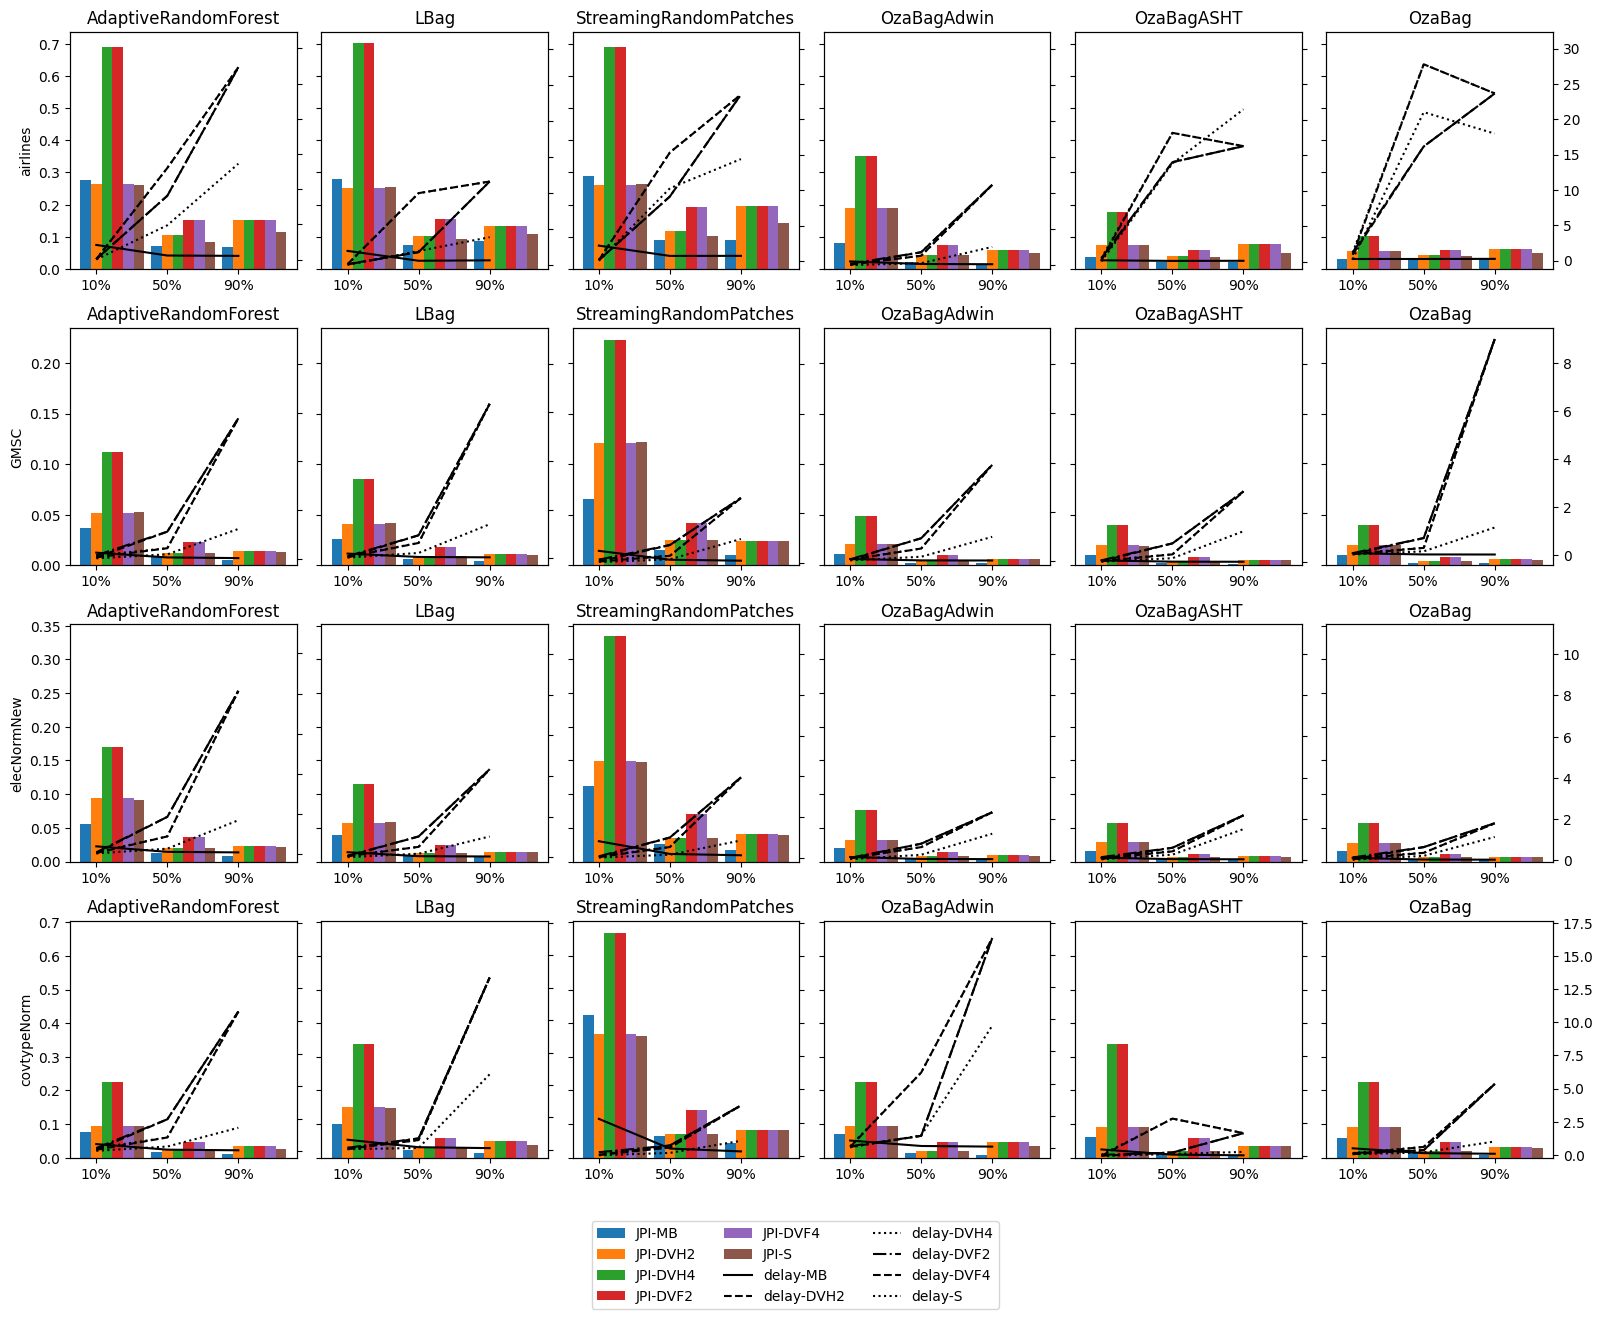

In [771]:
df2 = dataframes_with_mb
df2 = select_columns_and_rename_values_basic(df2)

df2 = build_label(df2.reset_index())

gen_graph(df2, bars=True, freq=f"{f['minimum']}x{f['maximum']}")

In [582]:
def build_label(df):
    for index, row in df.iterrows():
        if ((row['algorithm'].find('Sequential') > 0 or row['batch_size'] == 1) and row['cores'] == 1):
            df.at[index, 'label'] = "S"

        if (row['cores'] == 4 and row['batch_size'] == 50):
            df.at[index, 'label'] = "MB"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 2 and row['frequency_maximum'] == "600"):
            df.at[index, 'label'] = "DVH2"
            
        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 4 and row['frequency_maximum'] == "600"):
            df.at[index, 'label'] = "DVH4"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 2 and row['frequency_maximum'] == "1200"):
            df.at[index, 'label'] = "DVF2"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 4 and row['frequency_maximum'] == "1200"):
            df.at[index, 'label'] = "DVF4"

    return df

In [583]:
def gen_graph_joules(df_minimum, df_maximum, execution='first', only_eficiency=False):
    filename = f"pi-rates"
    fig, axs = plt.subplots(4, 6, figsize=(24, 10))
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']

    for ds in datasets:
        current_df = df_minimum[(df_minimum.dataset == ds)]
#         current_df_max = df_maximum[(df_maximum.dataset == ds)]

        my_id_ds = datasets.index(ds)

        #selects the correct position in the grid
        for alg in algorithms:            
            dfalg = build_label(
                filter_by_substring_algorithm(
                    current_df.reset_index(), alg
                )
            )
            
            df_mapping = pd.DataFrame({
                'label': ['MB', 'DVH2', 'DVH4', 'DVF2', 'DVF4', 'S'],
            })
            sort_mapping = df_mapping.reset_index().set_index('label')
            dfalg['label_num'] = dfalg['label'].map(sort_mapping['index'])

            dfalg = dfalg.drop_duplicates().sort_values('label_num')


            dfalg = dfalg.iloc[:-1 , :] # remove duplicidade sequencial
#             dfalg = dfalg.iloc[1: , :] # remove duplicidade sequencial

#             display(dfalg)           
            my_id = algorithms.index(alg)
            
            c1 = 'tab:red'
            c2 = 'tab:blue'
            
            labels = dfalg.label
            x = np.arange(len(labels))
            alg_order = algorithms.index(alg)
            
            ax = axs[int(my_id_ds)][my_id%6]
            ax.plot(x, pd.to_numeric(dfalg.JPI), color=c1, linewidth=0.75, label='JPI')
            ax.tick_params(axis='y', labelcolor=c1)

            ax2 = ax.twinx()
            ax2.plot(x, pd.to_numeric(dfalg.IPS), color=c2, linewidth=0.7, label='IPS')
            ax2.tick_params(axis='y', labelcolor=c2)
            
            ax.set_title(f'{alg}')
            
            #if its the first column, print Y-axis label
            if my_id%6 == 0:
                ax.set_ylabel(f'{ds}')

            #if its the last row, print the X-axis label
            if int(my_id/6) == 1:
                ax.set_xlabel('Cores')

            ax.set_xticks(x)
            ax.set_xticklabels(labels)

    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/6), bbox_to_anchor=(0.5,-0.1))

    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
#     plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_46456/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

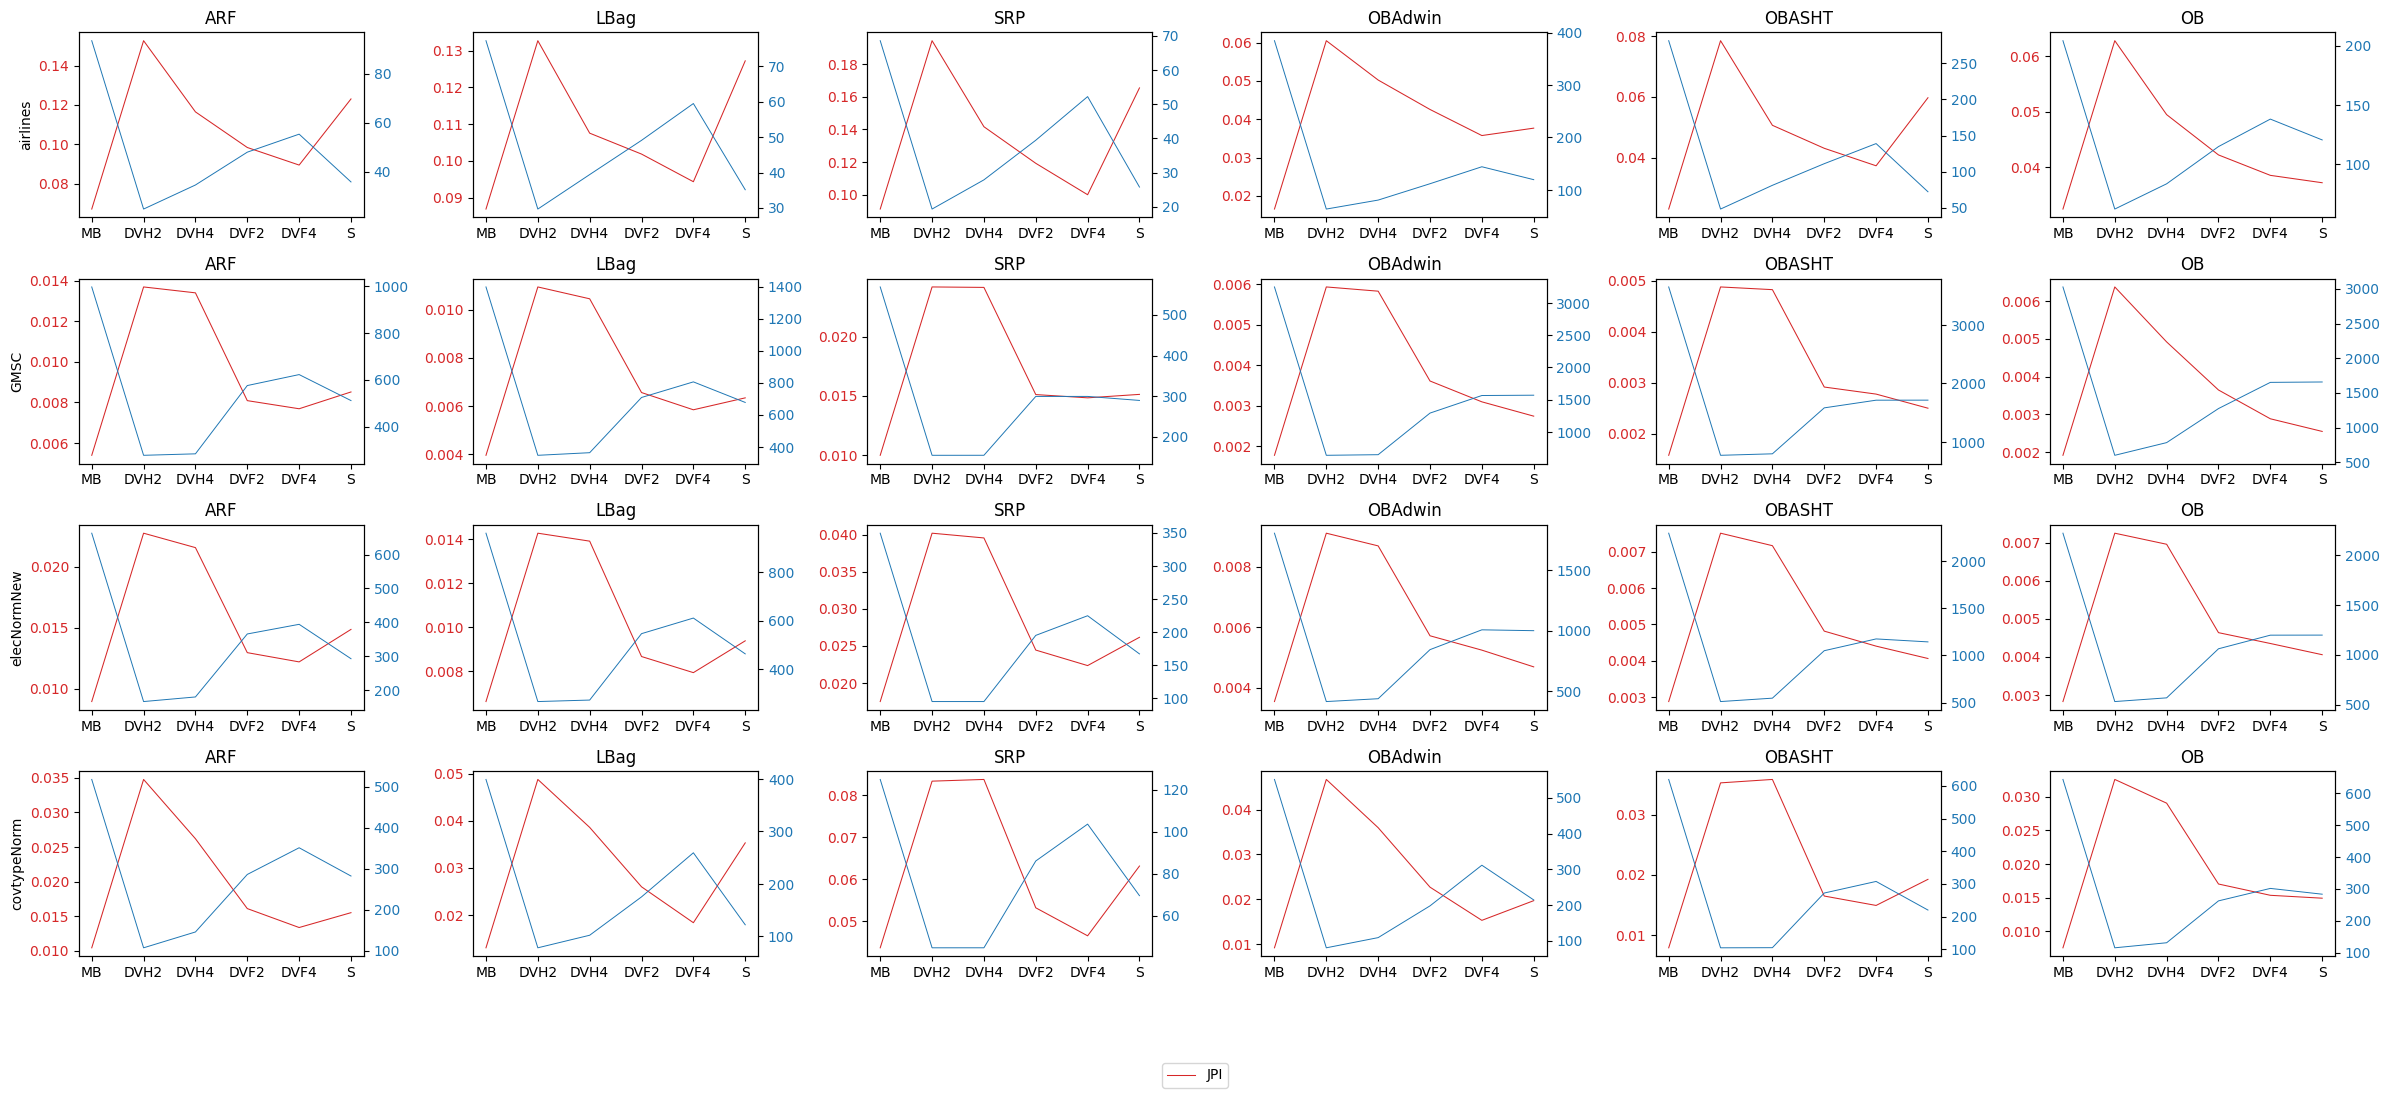

In [773]:
df = dataframes_with_mb
df = df[df.PERC == '90']
df = df.loc[:,['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'frequency_maximum']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']

# df2 = dataframes_maximum_freq_mb
# df2 = df2[df2.PERC == '90']
# df2 = df2.loc[:,['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'cores']]
# df2 = select_columns_and_rename_values(df2)
# df2['IPS'] = df2['instances'] / df2['time']

gen_graph_joules(df, None)

Beforehand, it is necessary to analyse in detail the for minimum frequency. The figure X show in details JPI consumer by execution and IPS are 24 executions with 4 datasets diffentes and four methods differents. In MB are executions with mini-batching, PLR-2 and PLR-4 are executions parallels with respective cores and finally, SEQ represent sequential execution, in other words, original MOA implementation.

A trend can be observed with all experiments. First execution MB had low consumer JPI and high consumer IPS and then JPI is increased with 2 cores and decrease 4 cores, after increased again in SEQ, while IPS trend a decrease. But is visible the experiments parallel with minimum frequency is better result in JPI and IPS that original implementation SEQ.

Is necessary, we also see the results to maximum frequency. In same figure we can see this data, firstly same similar trend with JPI and IPS. Increase JPI when used PLR-2 and PLR-4, after more JPI in sequential and IPS decrease in all experiments. The main change is values absolutes. If we look to the dasheds lines can be results with maximum frequency, a trend of decrease IPS and increase JPI is visible, but when compared in JPI can see maximum frequency consume minus JPI and more IPS in all scenaries.

This can yield a result that is different from what you intended as it with minimum frequency we should consume minus energy, but the instructions in CPU also reduce and in this way reduce performance in IPS consequently JPI be major.